In [ ]:
pip install -r '/content/drive/MyDrive/A+/Seminar FDA/requirements.txt'

# 1. Data collection and preprocessing
The first step of the project is to collect the S&P100 stocks and their historical values. The S&P100 is a stock market index made up of 100 major companies in the United States that are listed on the NYSE or NASDAQ. The index is a subset of the S&P 500 and is used as a benchmark for the US stock market.
The data is first collected then normalized.

## S&P100 stocks
The Wikipedia page is used to retrieve the S&P100 stocks list.
Notes:
- Alphabet Inc. (Google) is listed twice in the table due to the two different classes of shares. GOOGL is kept, as the oldest class of shares, and GOOG is deleted.
- Berkshire Hathaway is listed as BRK.B on wikipedia, while being listed as BRK-B on yahoo! finance. The symbol is changed in this list to the yfinance value.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import wikipedia as wp
import yfinance as yf
from ta.momentum import rsi
from ta.trend import macd

In [ ]:
html = wp.page("S&P 100").html().encode("UTF-8")
stocks = pd.read_html(html)[2].set_index("Symbol")
stocks = stocks.drop("GOOG")
stocks.loc["GOOGL", "Name"] = "Alphabet"
stocks = stocks.rename(index={"BRK.B": "BRK-B"})
stocks.head()

,Name,Sector
Symbol,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology


## Fundamentals
The fundamentals of the stocks, such as market capitalization or P/E Ratio, are collected via yfinance. These values will be used to find similarities between stock to create the graph.


In [ ]:
fundamentals = [
        yf.Ticker(stock).info for stock in stocks.index
]
fundamentals = pd.DataFrame(fundamentals).set_index("symbol")
fundamentals.index = fundamentals.index.rename("Symbol")  # for consistency with the stocks dataframe
fundamentals = fundamentals[["marketCap", "trailingPE", "forwardPE", "priceToBook", "trailingEps", "forwardEps", "bookValue", "payoutRatio", "beta", "fiveYearAvgDividendYield", "52WeekChange", "averageVolume", "enterpriseToRevenue", "profitMargins"]].fillna(0)
fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,3990206545920,36.246983,32.495790,54.105390,7.45,8.31,4.991,0.1367,1.109,0.53,0.212464,54006582,9.727,0.26915
ABBV,381382262784,163.553020,17.798021,-2075.865200,1.32,12.13,-0.104,4.9015,0.352,3.78,0.073012,5441835,7.470,0.04004
ABT,218750091264,15.804021,24.379847,4.293076,7.96,5.16,29.303,0.2915,0.719,1.71,0.077055,5798284,5.116,0.31880
ACN,150631727104,19.991770,17.263681,4.842021,12.15,14.07,50.165,0.4872,1.262,1.45,-0.317946,4840395,2.130,0.11021
ADBE,140377505792,20.920149,16.318735,11.966529,16.03,20.55,28.024,0.0000,1.536,0.12,-0.335717,4322353,6.086,0.30012


In [ ]:
normalized_fundamentals = (fundamentals - fundamentals.mean()) / fundamentals.std()
normalized_fundamentals.head()

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,4.274317,-0.103599,0.010594,0.322785,-0.178750,-0.203437,-0.100768,-0.469193,0.376428,-0.999637,0.311895,1.577143,0.270263,0.704933
ABBV,-0.080242,0.858125,-0.246036,-9.862554,-0.548083,-0.026418,-0.100873,5.133625,-1.332353,1.033417,-0.096540,-0.354444,0.082215,-1.253307
ABT,-0.276481,-0.258034,-0.131114,0.084587,-0.148022,-0.349407,-0.100267,-0.287167,-0.503921,-0.261482,-0.084699,-0.340266,-0.113916,1.129299
ACN,-0.358675,-0.226398,-0.255365,0.087212,0.104425,0.063481,-0.099837,-0.057048,0.721796,-0.424127,-1.241596,-0.378365,-0.362703,-0.653553
ADBE,-0.371049,-0.219385,-0.271865,0.121281,0.338196,0.363763,-0.100293,-0.629935,1.340298,-1.256115,-1.293646,-0.398969,-0.033097,0.969638


In [ ]:
normalized_fundamentals.to_csv("/content/drive/MyDrive/A+/Seminar FDA/data/SP100/raw/fundamentals.csv")

## Historical values
The historical values of the stocks will be obtained using the yfinance library. The values for the last five years will be retrieved. Multi-level indexing is used to store the historical values for each stock, indexing by Symbol and Date.
The features are the normalized close price, daily log returns and annualized log returns (denoted AR) for one week, two weeks, one month and two months. Log returns are used for their normal distribution advantage, and to handle large annualized returns.
The daily variations are computed and the closed price is normalized. Two technical indicators are used:
- RSI: It indicates if a stock is overbought or oversold.
- MACD: Provides trade signals through the momentum.

These indicators can help a trading model to have more in-depth information on the current prices.


In [ ]:
values = [
	yf.Ticker(stock).history(period="5y", actions=False) for stock in stocks.index
]

for idx, stock_values in enumerate(values):
	stock_values["NormClose"] = (stock_values["Close"] - stock_values["Close"].mean()) / stock_values["Close"].std()
	# Log returns
	stock_values["DailyLogReturn"] = np.log(1 + stock_values["Close"].pct_change())
	stock_values["ALR1W"] = stock_values["DailyLogReturn"].rolling(window=5).sum() * 5
	stock_values["ALR2W"] = stock_values["DailyLogReturn"].rolling(window=10).sum() * 5
	stock_values["ALR1M"] = stock_values["DailyLogReturn"].rolling(window=21).sum() * 21
	stock_values["ALR2M"] = stock_values["DailyLogReturn"].rolling(window=42).sum() * 21
	# Normalizing the standard deviation
	stock_values["DailyLogReturn"] /= stock_values["DailyLogReturn"].std()
	stock_values["ALR1W"] /= stock_values["ALR1W"].std()
	stock_values["ALR2W"] /= stock_values["ALR2W"].std()
	stock_values["ALR1M"] /= stock_values["ALR1M"].std()
	stock_values["ALR2M"] /= stock_values["ALR2M"].std()
	stock_values["RSI"] = rsi(stock_values["Close"]) / 100
	stock_values["MACD"] = macd(stock_values["Close"])
	stock_values.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)
values = pd.concat(values, keys=stocks.index).dropna()
values.head(n=10)

Close  NormClose  DailyLogReturn  \
Symbol Date                                                               
AAPL   2021-01-07 00:00:00-05:00  127.567917  -1.256391        1.899199   
       2021-01-08 00:00:00-05:00  128.668976  -1.227216        0.486438   
       2021-01-11 00:00:00-05:00  125.677582  -1.306480       -1.331445   
       2021-01-12 00:00:00-05:00  125.502205  -1.311128       -0.079039   
       2021-01-13 00:00:00-05:00  127.538689  -1.257166        0.911077   
       2021-01-14 00:00:00-05:00  125.609398  -1.308287       -0.862754   
       2021-01-15 00:00:00-05:00  123.884720  -1.353987       -0.782547   
       2021-01-19 00:00:00-05:00  124.557053  -1.336172        0.306349   
       2021-01-20 00:00:00-05:00  128.649506  -1.227732        1.829794   
       2021-01-21 00:00:00-05:00  133.365555  -1.102769        2.037767   

                                     ALR1W     ALR2W     ALR1M     ALR2M  \
Symbol Date                                                                
AAPL   2021-01-07 00:00:00-05:00 -0.541765 -0.138224  0.762286  0.958248   
       2021-01-08 00:00:00-05:00 -0.123786  0.156812  0.809874  1.054442   
       2021-01-11 00:00:00-05:00 -0.085215 -0.433568  0.777421  1.021294   
       2021-01-12 00:00:00-05:00 -0.435546 -1.124814  0.597226  1.037280   
       2021-01-13 00:00:00-05:00  0.853158 -0.566698  0.906534  0.900813   
       2021-01-14 00:00:00-05:00 -0.396098 -0.693064  0.770076  0.773324   
       2021-01-15 00:00:00-05:00 -0.970071 -0.808341 -0.078542  0.632503   
       2021-01-19 00:00:00-05:00 -0.229282 -0.232408  0.002120  0.600176   
       2021-01-20 00:00:00-05:00  0.634100  0.146728  0.345733  0.994818   
       2021-01-21 00:00:00-05:00  1.143712  1.475653  1.049239  1.463970   

                                       RSI      MACD  
Symbol Date                                           
AAPL   2021-01-07 00:00:00-05:00  0.559839  2.318804  
       2021-01-08 00:00:00-05:00  0.577422  2.290092  
       2021-01-11 00:00:00-05:00  0.516998  2.002869  
       2021-01-12 00:00:00-05:00  0.513604  1.741022  
       2021-01-13 00:00:00-05:00  0.550499  1.678485  
       2021-01-14 00:00:00-05:00  0.510957  1.456457  
       2021-01-15 00:00:00-05:00  0.477909  1.128325  
       2021-01-19 00:00:00-05:00  0.491710  0.912016  
       2021-01-20 00:00:00-05:00  0.566782  1.058613  
       2021-01-21 00:00:00-05:00  0.633888  1.537614

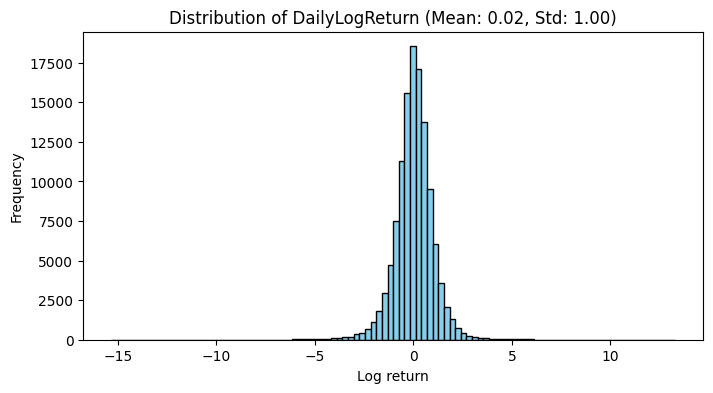

In [ ]:
plt.figure(figsize=(8, 4))

column = "DailyLogReturn"
plt.hist(values[column], bins=100, color="skyblue", edgecolor="black")
plt.title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
plt.xlabel("Log return")
plt.ylabel("Frequency")
plt.show()

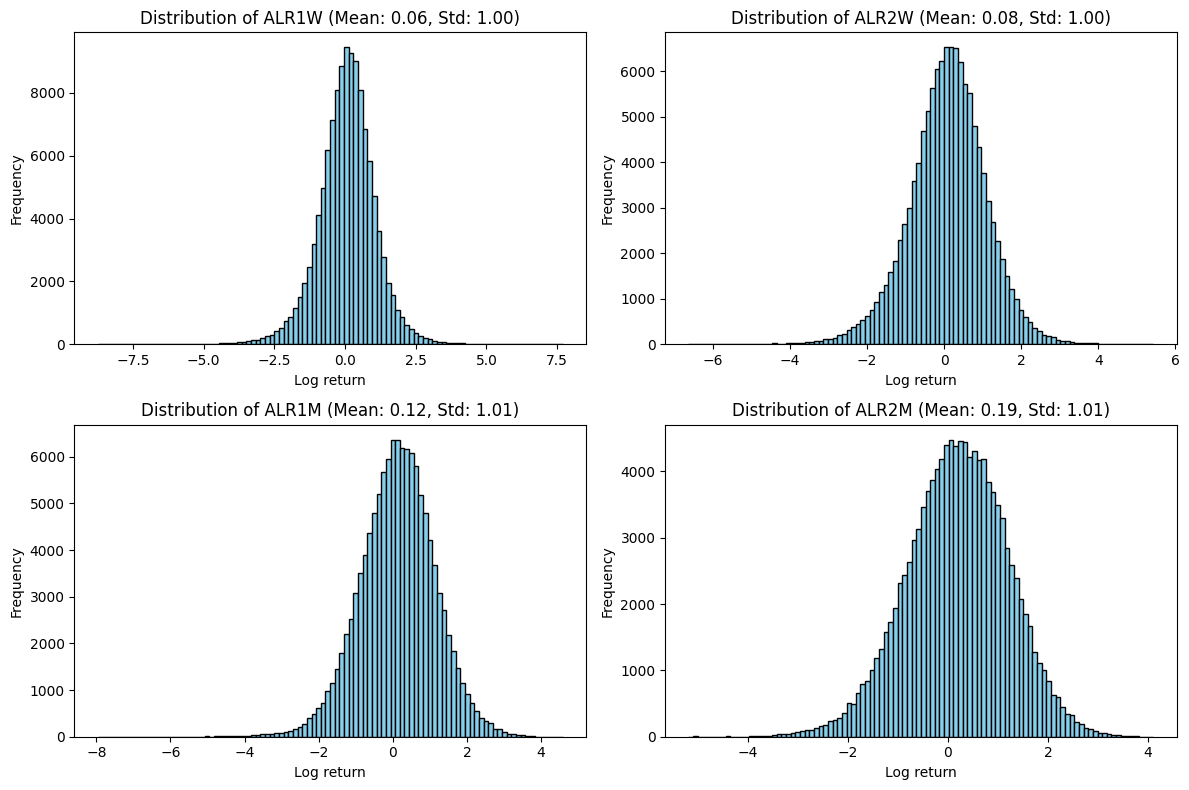

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for idx, column in enumerate(["ALR1W", "ALR2W", "ALR1M", "ALR2M"]):
	ax = axs[idx // 2, idx % 2]
	ax.hist(values[column], bins=100, color="skyblue", edgecolor="black")
	ax.set_title(f"Distribution of {column} (Mean: {values[column].mean():.2f}, Std: {values[column].std():.2f})")
	ax.set_xlabel("Log return")
	ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

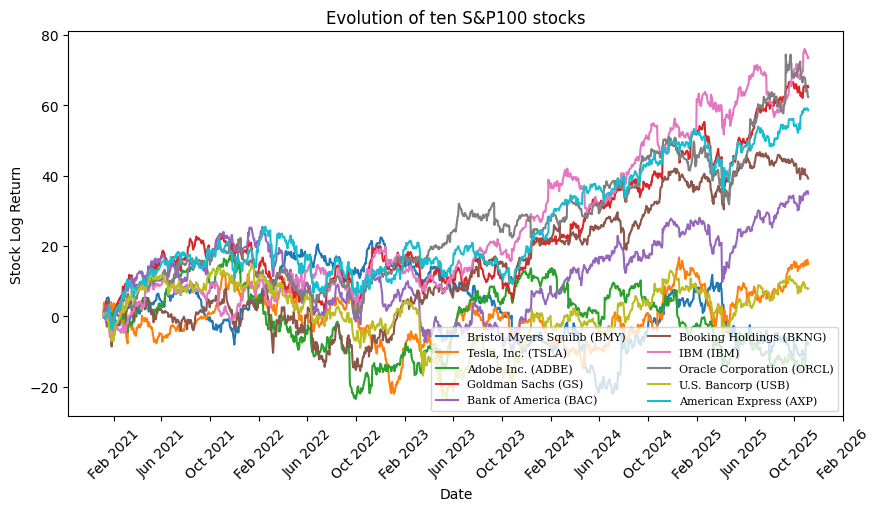

In [ ]:
plt.figure(figsize=(10, 5))

for stock in np.random.choice(stocks.index, size=10, replace=False):
	plt.plot(values.loc[stock].index, np.cumsum(values.loc[stock]["DailyLogReturn"]), label=f'{stocks.loc[stock]["Name"]} ({stock})')
plt.title(f"Evolution of ten S&P100 stocks")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Stock Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()

In [ ]:
values.to_csv("/content/drive/MyDrive/A+/Seminar FDA/data/SP100/raw/values.csv")

# Graph creation

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

After collecting and pre-processing the data, the graphs are created to build a network between the stocks, using their sectors and correlation.[văn bản liên kết](https://)

## Grouping by sector
The first step is to create a graph of the stocks linking every stock that belong to the same activity sector.

In [ ]:
stocks = pd.read_csv('/content/drive/MyDrive/A+/Seminar FDA/data/SP100/raw/stocks.csv').set_index('Symbol')
stocks.head(n=10)

,Name,Sector
Symbol,,
AAPL,Apple,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe,Information Technology
AIG,American International Group,Financials
AMD,AMD,Information Technology
AMGN,Amgen,Health Care
AMT,American Tower,Real Estate


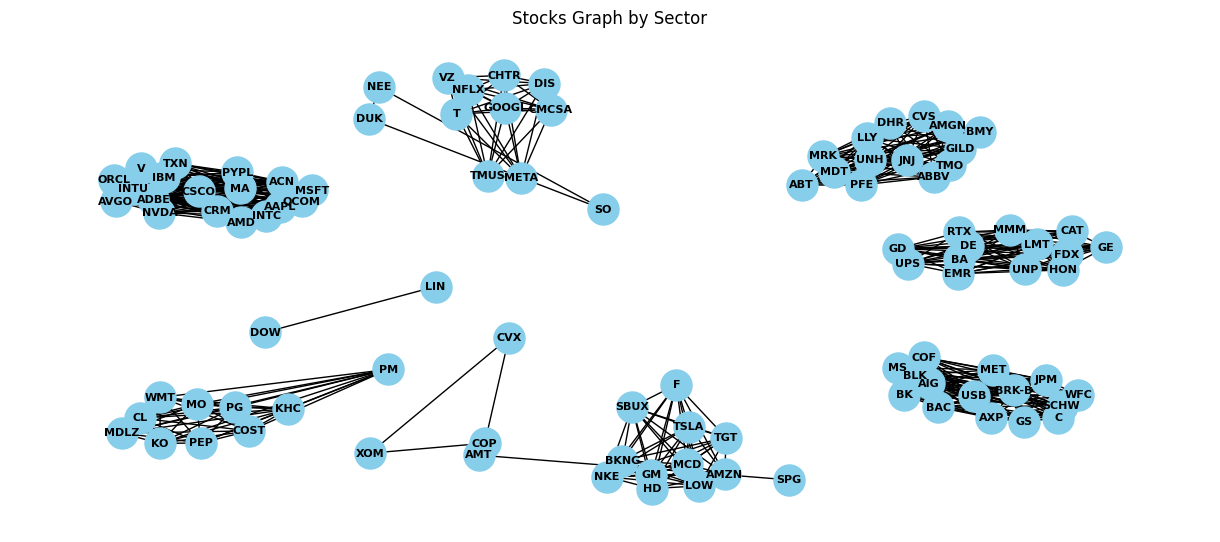

In [ ]:
adj_stocks = np.array([
	[stocks.loc[stock1, 'Sector'] == stocks.loc[stock2, 'Sector'] * (stock1 != stock2) for stock1 in stocks.index] for stock2 in stocks.index
]).astype(int)
stocks_graph = nx.from_numpy_array(adj_stocks)
stocks_graph = nx.relabel_nodes(stocks_graph, dict(enumerate(stocks.index)))

plt.figure(figsize=(12, 5))
nx.draw(stocks_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(stocks_graph, k=.5))
plt.title('Stocks Graph by Sector')
plt.show()

## Graph by fundamentals correlation
A great way to link the stocks would be using their fundamental data, such as market capitalization, p/e ratio, etc. An autoencoder is built to reduce the dimensionality of the fundamental data, and the stocks are clustered and linked following these clusters. Furthermore, the correlation between the fundamental data is used to link the stocks that have a high correlation.


In [ ]:
fundamentals = pd.read_csv('/content/drive/MyDrive/A+/Seminar FDA/data/SP100/raw/fundamentals.csv').set_index("Symbol")
fundamentals.head(n=10)

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,4.274317,-0.103599,0.010594,0.322785,-0.178750,-0.203437,-0.100768,-0.469193,0.376428,-0.999637,0.311895,1.577143,0.270263,0.704933
ABBV,-0.080242,0.858125,-0.246036,-9.862554,-0.548083,-0.026418,-0.100873,5.133625,-1.332353,1.033417,-0.096540,-0.354444,0.082215,-1.253307
ABT,-0.276481,-0.258034,-0.131114,0.084587,-0.148022,-0.349407,-0.100267,-0.287167,-0.503921,-0.261482,-0.084699,-0.340266,-0.113916,1.129299
ACN,-0.358675,-0.226398,-0.255365,0.087212,0.104425,0.063481,-0.099837,-0.057048,0.721796,-0.424127,-1.241596,-0.378365,-0.362703,-0.653553
ADBE,-0.371049,-0.219385,-0.271865,0.121281,0.338196,0.363763,-0.100293,-0.629935,1.340298,-1.256115,-1.293646,-0.398969,-0.033097,0.969638
AIG,-0.486481,-0.263459,-0.346777,0.069264,-0.305275,-0.277580,-0.099343,-0.267294,-0.722880,0.082573,-0.170060,-0.399028,-0.412194,-0.597483
AMD,-0.050788,0.616778,0.299278,0.096564,-0.513138,-0.352188,-0.100113,-0.629935,2.191303,-1.331182,1.808041,1.825081,0.596453,-0.777230
AMGN,-0.347695,-0.204210,-0.306167,0.166877,0.152023,0.369324,-0.100586,0.223987,-1.086306,0.589273,-0.538743,-0.479197,-0.044095,0.024665
AMT,-0.438557,-0.160475,-0.093028,0.166228,-0.249243,-0.273873,-0.100697,0.630370,-0.056974,0.364073,-0.564302,-0.455671,0.530132,0.806730


In [ ]:
def get_clusters(data: np.ndarray, n_clusters: int) -> np.ndarray:
    kmeans = KMeans(n_clusters=n_clusters)
    return kmeans.fit(data).labels_

fundamentals_corr = fundamentals.transpose().corr(method="spearman")
fundamentals_corr = (fundamentals_corr - (fundamentals_corr == 1))  # Remove self-correlation
fundamentals_corr.head(n=10)

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UBER,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000000,-0.604396,0.151648,-0.235165,0.169231,-0.600000,0.516484,-0.692308,-0.221978,0.696703,...,0.648352,-0.265934,-0.116484,-0.516484,-0.076923,0.481319,-0.217582,0.573626,0.331868,-0.305495
ABBV,-0.604396,0.000000,-0.279121,-0.274725,-0.573626,0.323077,-0.274725,0.345055,0.059341,-0.419780,...,-0.797802,-0.050549,-0.375824,0.103297,-0.173626,-0.323077,0.305495,-0.564835,0.046154,0.296703
ABT,0.151648,-0.279121,0.000000,-0.367033,0.019780,0.265934,-0.173626,0.076923,0.252747,-0.169231,...,0.397802,-0.283516,0.129670,-0.468132,0.054945,0.591209,0.006593,0.367033,0.169231,-0.142857
ACN,-0.235165,-0.274725,-0.367033,0.000000,0.560440,-0.015385,0.041758,0.156044,0.054945,0.076923,...,-0.120879,0.578022,0.402198,0.582418,0.068132,-0.191209,-0.116484,-0.327473,-0.173626,0.098901
ADBE,0.169231,-0.573626,0.019780,0.560440,0.000000,-0.463736,-0.010989,0.076923,0.274725,-0.120879,...,0.345055,0.151648,0.731868,0.032967,0.230769,0.389011,-0.402198,0.116484,-0.551648,-0.454945
AIG,-0.600000,0.323077,0.265934,-0.015385,-0.463736,0.000000,-0.274725,0.472527,-0.054945,-0.287912,...,-0.415385,0.270330,-0.151648,0.406593,0.068132,-0.331868,0.512088,-0.116484,0.248352,0.582418
AMD,0.516484,-0.274725,-0.173626,0.041758,-0.010989,-0.274725,0.000000,-0.828571,-0.459341,0.767033,...,0.476923,-0.217582,-0.397802,-0.287912,-0.309890,-0.019780,-0.301099,0.178022,0.410989,-0.441758
AMGN,-0.692308,0.345055,0.076923,0.156044,0.076923,0.472527,-0.828571,0.000000,0.485714,-0.841758,...,-0.630769,0.424176,0.463736,0.468132,0.336264,-0.059341,0.459341,-0.345055,-0.389011,0.534066
AMT,-0.221978,0.059341,0.252747,0.054945,0.274725,-0.054945,-0.459341,0.485714,0.000000,-0.652747,...,-0.046154,-0.283516,0.701099,0.292308,0.753846,0.015385,0.208791,0.120879,-0.556044,0.002198


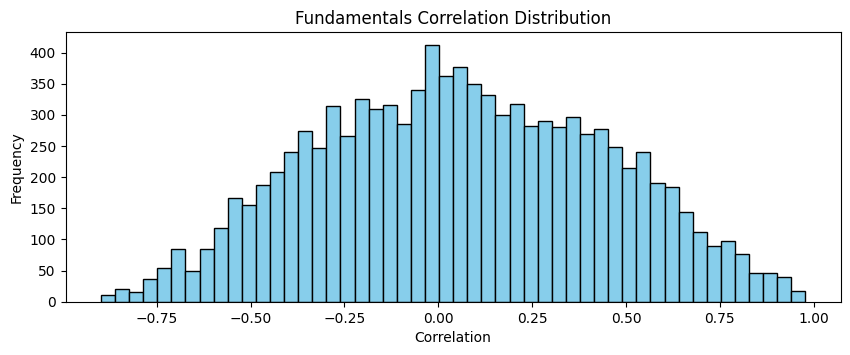

In [ ]:
plt.figure(figsize=(10, 3.5))
plt.hist(fundamentals_corr.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Fundamentals Correlation Distribution')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

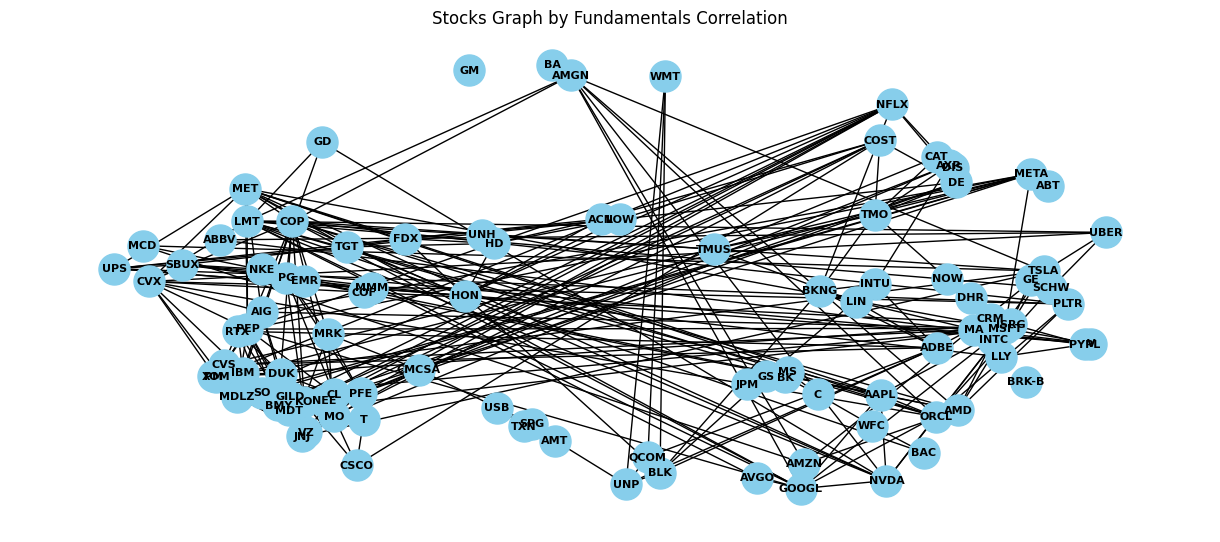

In [ ]:
fundamentals_corr_np = fundamentals_corr.to_numpy()
adj_fundamentals_corr = (fundamentals_corr_np * (abs(fundamentals_corr_np) > .7).astype(int))

fundamentals_corr_graph = nx.from_numpy_array(adj_fundamentals_corr)
fundamentals_corr_graph = nx.relabel_nodes(fundamentals_corr_graph, dict(enumerate(fundamentals_corr.index)))

plt.figure(figsize=(12, 5))
nx.draw(fundamentals_corr_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(fundamentals_corr_graph))
plt.title('Stocks Graph by Fundamentals Correlation')
plt.show()

## Merging the graphs
To make use of the two graphs to build the final adjacency matrix. A correlation bonus is given to two stocks sharing the same sector.


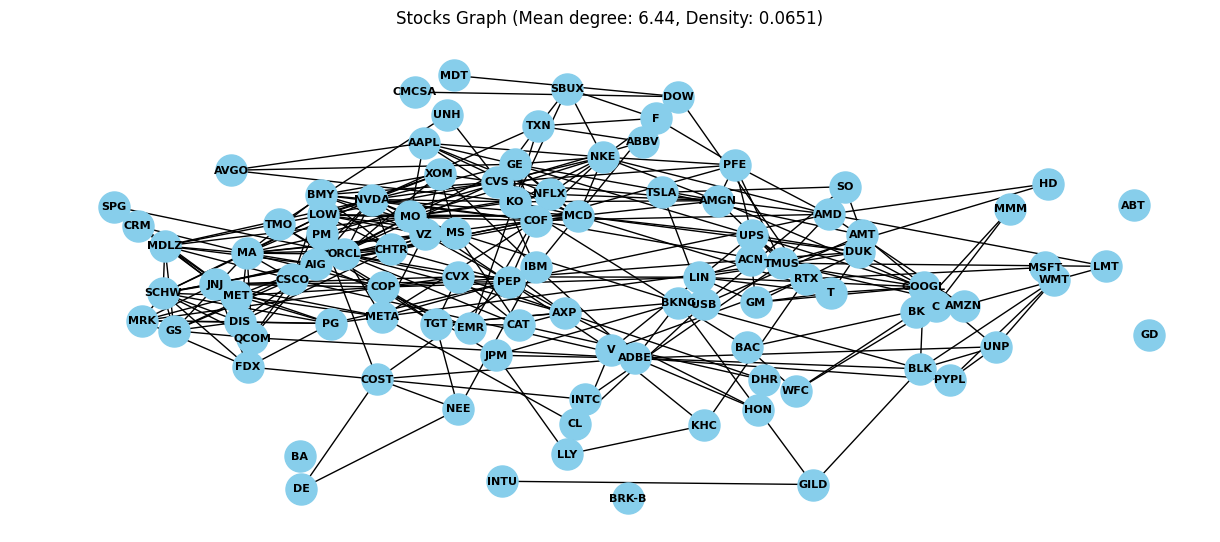

In [ ]:
corr_threshold, sector_bonus = .7, .05

share_sector = pd.get_dummies(stocks[["Sector"]]).transpose().corr().to_numpy().astype(int) - np.eye(len(stocks), dtype=int)
# abs because GCNConv only accepts positive weights
adj = abs(fundamentals_corr_np) + share_sector * sector_bonus
adj = adj * (abs(adj) > corr_threshold)
adj = adj / adj.max()

graph = nx.from_numpy_array(adj)
graph = nx.relabel_nodes(graph, dict(enumerate(stocks.index)))

plt.figure(figsize=(12, 5))
nx.draw(graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(graph, k=.5))
plt.title(f'Stocks Graph (Mean degree: {np.mean([degree for node, degree in graph.degree]):.2f}, Density: {nx.density(graph):.4f})')
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/A+/Seminar FDA/data/SP100/raw/adj.npy', adj)

# Torch geometric dataset

In [ ]:
import numpy as np
import pandas as pd
from torch_geometric.data import Data

# PyTorch Geometric custom Dataset
This module illustrates the process part of the custom dataset creation for PyG done in the `datasets/SP100Stocks.py` file.
The Dataset class is used to create a custom dataset and use it with PyG modules.
**Note: To use this notebook, first execute notebooks 1 and 2.**

## Processing the graph data
The next cells demonstrate the adjacency matrix and historical values processing done in the `Dataset.process(*)` method.   

### Opening the historical values and the adjacency matrix
The goal is here to create T (the number of timestamps) graphs, one for each timestep. We use the same adjacency matrix for all the graphs as the structure is based on fundamentals and will not change.


In [ ]:
values = pd.read_csv('/content/drive/MyDrive/A+/Seminar FDA/data/SP100/raw/values.csv').set_index(['Symbol', 'Date'])
values.head()

Close  NormClose  DailyLogReturn  \
Symbol Date                                                              
AAPL   2019-07-15 00:00:00-04:00  49.511902  -1.878514        0.467707   
       2019-07-16 00:00:00-04:00  49.340588  -1.882460       -0.173360   
       2019-07-17 00:00:00-04:00  49.063126  -1.888850       -0.282057   
       2019-07-18 00:00:00-04:00  49.620468  -1.876013        0.564969   
       2019-07-19 00:00:00-04:00  48.879761  -1.893074       -0.752247   

                                     ALR1W     ALR2W     ALR1M     ALR2M  \
Symbol Date                                                                
AAPL   2019-07-15 00:00:00-04:00  0.633085  0.634757  0.659704  0.708706   
       2019-07-16 00:00:00-04:00  0.397142  0.254992  0.705224  0.579130   
       2019-07-17 00:00:00-04:00  0.014587  0.053587  0.567239  0.568764   
       2019-07-18 00:00:00-04:00  0.474382  0.106986  0.424941  0.711992   
       2019-07-19 00:00:00-04:00 -0.086464 -0.141485  0.280707  0.852990   

                                       RSI      MACD  
Symbol Date                                           
AAPL   2019-07-15 00:00:00-04:00  0.650353  0.846854  
       2019-07-16 00:00:00-04:00  0.631509  0.836484  
       2019-07-17 00:00:00-04:00  0.601130  0.796694  
       2019-07-18 00:00:00-04:00  0.638726  0.800901  
       2019-07-19 00:00:00-04:00  0.562803  0.735982

In [ ]:
adj = np.load('/content/drive/MyDrive/A+/Seminar FDA/data/SP100/raw/adj.npy')
adj[:10, :10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.88339223, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.72791519, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.7385159 ],
       [0.        , 0.88339223, 0.       

### Creating the feature matrix and edge indices
The feature matrix is a 3D matrix of shape (stocks_nb, features_nb, timestamps_nb). The adjacency matrix is used to create the edge_index matrix in the PyTorch Geomtric format.

In [ ]:
nodes_nb = len(adj)
x = np.array(
	values.drop(columns=["Close"]).to_numpy().reshape((nodes_nb, -1, values.shape[1] - 1))
)  # shape (nodes_nb, timestamps_nb, features_nb)
x = np.swapaxes(x, 1, 2)  # shape (nodes_nb, features_nb, timestamps_nb)

edge_nb = np.count_nonzero(adj)
edge_index = np.zeros((2, edge_nb))
edge_weight = np.zeros((edge_nb,))
count = 0
for i in range(nodes_nb):
	for j in range(nodes_nb):
		if (weight := adj[i, j]) != 0:
			edge_index[0, count], edge_index[1, count] = i, j
			edge_weight[count] = weight
			count += 1
x.shape, edge_index.shape, edge_weight.shape

((100, 8, 1217), (2, 524), (524,))

### Building the graphs
Finally, the graphs can be built using the Data class for PyG.


In [ ]:
past_window, future_window = 25, 1
timestamps = [
	Data(x=x[:, :, idx:idx+past_window], edge_index=edge_index, edge_weight=edge_weight, y=x[:, 0, idx+past_window:idx+past_window+future_window]) for idx in range(x.shape[0] - past_window - future_window)
]
timestamps[:5]

[Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524]),
 Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524]),
 Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524]),
 Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524]),
 Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524])]

## Defining the PyTorch Geometric datasets
The previously defined method is used to process the data and create a standard PyG Dataset class.
The dataset contains graphs with 3d node features -- data for the timestamps $[\![t, t+T[\![$ -- and a target variable -- the variation at time $t+T$ --.

These dataset is used in the next notebooks. The code is in the `datasets/SP100Stocks.py` file.


In [ ]:
import numpy as np
import pandas as pd
import torch


def get_graph_in_pyg_format(values_path: str, adj_path: str) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
	"""
	Creates the PyTorch Geometric graph data from the stock price data and adjacency matrix.
	:param values_path: Path of the CSV file containing the stock price data
	:param adj_path: Path of the NumPy file containing the adjacency matrix
	:return: The graph data in PyTorch Geometric format
		x: Node features (nodes_nb, timestamps_nb, features_nb)
		close_prices: Close prices (nodes_nb, timestamps_nb)
		edge_index: Edge index (2, edge_nb)
		edge_weight: Edge weight (edge_nb,)
	"""
	values = pd.read_csv(values_path).set_index(['Symbol', 'Date'])
	adj = np.load(adj_path)
	nodes_nb, edge_nb = len(adj), np.count_nonzero(adj)
	x = torch.tensor(
		values.drop(columns=["Close"]).to_numpy().reshape((nodes_nb, -1, values.shape[1] - 1)), dtype=torch.float32
	)
	x = x.transpose(1, 2)
	close_prices = torch.tensor(
		values[["Close"]].to_numpy().reshape((nodes_nb, -1)), dtype=torch.float32
	)
	edge_index, edge_weight = torch.zeros((2, edge_nb), dtype=torch.long), torch.zeros((edge_nb,), dtype=torch.float32)
	count = 0
	for i in range(nodes_nb):
		for j in range(nodes_nb):
			if (weight := adj[i, j]) != 0:
				edge_index[0, count], edge_index[1, count] = i, j
				edge_weight[count] = weight
				count += 1

	return x, close_prices, edge_index, edge_weight

In [ ]:
import os, os.path as osp
from typing import Callable
import pandas as pd
import torch
from torch_geometric.data import Dataset, Data

class SP100Stocks(Dataset):
    """
    Stock price data for the S&P 100 companies.
    The graph data built from the notebooks is used.
    """

    def __init__(self,
                 root: str = "/content/drive/MyDrive/A+/Seminar FDA/data/SP100",
                 values_file_name: str = "values.csv",
                 adj_file_name: str = "adj.npy",
                 past_window: int = 25,
                 future_window: int = 1,
                 force_reload: bool = False,
                 transform: Callable | None = None):
        self.values_file_name = values_file_name
        self.adj_file_name = adj_file_name
        self.past_window = int(past_window)
        self.future_window = int(future_window)
        super().__init__(root, force_reload=force_reload, transform=transform)

    @property
    def raw_file_names(self) -> list[str]:
        # các file sẽ nằm trong <root>/raw/
        return [self.values_file_name, self.adj_file_name]

    @property
    def processed_file_names(self) -> list[str]:
        # để rỗng để PyG luôn gọi process() khi cần
        return []

    def download(self) -> None:
        pass

    def process(self) -> None:
        # dùng đường dẫn trong <root>/raw/ thay vì hard-code
        values_path = osp.join(self.raw_dir, self.values_file_name)
        adj_path    = osp.join(self.raw_dir, self.adj_file_name)

        x, close_prices, edge_index, edge_weight = get_graph_in_pyg_format(
            values_path=values_path,
            adj_path=adj_path,
        )

        last = x.shape[2] - self.past_window - self.future_window
        os.makedirs(self.processed_dir, exist_ok=True)

        for idx in range(max(last, 0)):
            data = Data(
                x=x[:, :, idx:idx + self.past_window],
                edge_index=edge_index,
                edge_weight=edge_weight,
                close_price=close_prices[:, idx:idx + self.past_window],
                y=x[:, 0, idx + self.past_window:idx + self.past_window + self.future_window],
                close_price_y=close_prices[:, idx + self.past_window:idx + self.past_window + self.future_window],
            )
            torch.save(data, osp.join(self.processed_dir, f"timestep_{idx}.pt"))

    def len(self) -> int:
        if not osp.isdir(self.processed_dir):
            return 0
        return sum(
            f.startswith("timestep_") and f.endswith(".pt")
            for f in os.listdir(self.processed_dir)
        )

    def get(self, idx: int) -> Data:
        path = osp.join(self.processed_dir, f"timestep_{idx}.pt")
        # PyTorch 2.6+: phải tắt weights_only khi load object Data của PyG
        return torch.load(path, map_location="cpu", weights_only=False)

In [ ]:
from torch.serialization import add_safe_globals
from torch_geometric.data.data import DataEdgeAttr
add_safe_globals([DataEdgeAttr])


In [ ]:
dataset = SP100Stocks()
dataset, dataset[0]

Processing...
Done!


(SP100Stocks(1191),
 Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 1]))

# Spatio-Temporal Graph Neural Network models
This notebook will present an implementation of different Spatio-Temporal Graph Neural Network (STGNN) models, that will be used in the next notebooks. They combine multiple GCN layers and multiple GRU layers to model the spatial and temporal dependencies in the data.

## Graph Convolutional Network (GCN)
We define a simple Graph Convolutional Network (GCN) model, that will be used as a building block for the following models.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv

In [ ]:
class GCN(nn.Module):
	"""
	Simple two layers GCN model.
	"""
	def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True):
		super(GCN, self).__init__()
		layer_sizes = layer_sizes or [32, 32]
		self.convs = nn.ModuleList([
			GCNConv(in_channels, layer_sizes[0], bias=bias),
		] + [
			GCNConv(layer_sizes[i], layer_sizes[i + 1], bias=bias) for i in range(len(layer_sizes) - 1)
		])

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
		"""
		for conv in self.convs:
			x = F.relu(conv(x, edge_index, edge_weight))
		return x

## Graph Attention Network (GAT)
The Graph Attention Network (GAT) -- from the paper [Graph Attention Networks](https://arxiv.org/pdf/1710.10903) -- is a model that uses attention mechanisms to learn the importance of the different nodes in the graph at a given timestep.

In [ ]:
class GAT(nn.Module):
	"""
	Simple two layers GCN model.
	"""
	def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True):
		super(GAT, self).__init__()
		layer_sizes = layer_sizes or [32, 32]
		self.convs = nn.ModuleList([
		   GATv2Conv(in_channels, layer_sizes[0], bias=bias, edge_dim=1),
		] + [
		   GATv2Conv(layer_sizes[i], layer_sizes[i + 1], bias=bias, edge_dim=1) for i in
		   range(len(layer_sizes) - 1)
   		])

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
		"""
		for conv in self.convs[:-1]:
			x = F.relu(conv(x, edge_index, edge_weight))
		return self.convs[-1](x, edge_index, edge_weight)


## Temporal Graph Convolutional Network (T-GCN)
The Temporal Graph Convolutional Network (T-GCN) -- from the paper [T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction](https://arxiv.org/pdf/1811.05320) -- is a simple model that uses GCN layers followed by a GRU layer. The GCN layers are used to extract the spatial features of the graph at a given timestep, and the GRU layer is used to model the temporal dependencies between the different timestamps.
However, in the case of stock prices, the data on the stock itself is highly important. The drawback of using GCN is that the node feature is lost through the aggregation phase. To address this issue, we can concatenate the node feature with the output of the GCN layer before feeding it to the GRU layer.

In [ ]:
class TGCNCell(nn.Module):
	"""
	T-GCN Cell for one timestep, from https://arxiv.org/pdf/1811.05320.
	"""
	def __init__(self, in_channels: int, hidden_size: int, use_gat: bool = True):
		super(TGCNCell, self).__init__()
		if use_gat:
			self.gcn = GAT(in_channels, [hidden_size, hidden_size])
		else:
			self.gcn = GCN(in_channels, [hidden_size, hidden_size])
		self.lin_u = nn.Linear(2 * hidden_size + in_channels, hidden_size)
		self.lin_r = nn.Linear(2 * hidden_size + in_channels, hidden_size)
		self.lin_c = nn.Linear(2 * hidden_size + in_channels, hidden_size)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor, h: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
		"""
		Performs a forward pass on a single T-GCN cell (GCN + GRU).
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:param h: The hidden state of the GRU h_{t-1} (Nodes_nb, Hidden_size)
		:return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
		"""
		gcn_out = F.sigmoid(self.gcn(x, edge_index, edge_weight))  # f(A,X_t), Eq. 2
		u = F.sigmoid(self.lin_u(torch.cat([x, gcn_out, h], dim=-1)))  # u_t, Eq. 3
		r = F.sigmoid(self.lin_r(torch.cat([x, gcn_out, h], dim=-1)))  # r_t,  Eq. 4
		c = F.tanh(self.lin_c(torch.cat([x, gcn_out, r * h], dim=-1)))  # c_t, Eq. 5

		return u * h + (1 - u) * c  # h_t, Eq. 6

In [ ]:
class TGCN(nn.Module):
	"""
	T-GCN model from https://arxiv.org/pdf/1811.05320.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(TGCN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[TGCNCell(in_channels, hidden_size, use_gat=use_gat)] + [TGCNCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the T-GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size) for _ in range(self.layers_nb)
		]
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
		return self.out(h_prev[-1])

In [ ]:
# Example of usage
model = TGCN(2, 1, 32)
x = torch.rand(10, 2, 5)
edge_index = torch.tensor(
	[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9],
	 [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8]]
)
edge_weight = torch.rand(edge_index.shape[1])
model(x, edge_index, edge_weight)

tensor([[0.0937],
        [0.1024],
        [0.0895],
        [0.0909],
        [0.0890],
        [0.0953],
        [0.0886],
        [0.0927],
        [0.0939],
        [0.0953]], grad_fn=<AddmmBackward0>)

## Attention Temporal Graph Convolutional Network (A3T-GCN)
The Attention Temporal Graph Convolutional Network (A3T-GCN) -- from the paper [A3T-GCN: Attention Temporal Graph Convolutional Network for Traffic Forecasting](https://arxiv.org/pdf/2006.11583) -- is a model that extends the T-GCN model by adding an attention mechanism to the hidden states computed by the GRU cells. The attention mechanism is used to learn the importance of the different nodes in the graph at a given timestep.

In [ ]:
class A3TGCN(nn.Module):
	"""
	A3T-GCN model from https://arxiv.org/pdf/2006.11583.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(A3TGCN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[TGCNCell(in_channels, hidden_size, use_gat=use_gat)] + [TGCNCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.attention = nn.Sequential(
			nn.Linear(hidden_size, 1),
			nn.Softmax(dim=1),
		)
		nn.init.uniform_(self.attention[0].weight)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the A3T-GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size) for _ in range(self.layers_nb)
		]
		h_final = torch.zeros(x.shape[0], x.shape[-1], self.hidden_size)
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
			h_final[:, t, :] = h
		att = self.attention(h_final)
		c_t = self.out(torch.sum(h_final * att, dim=1))
		return c_t

In [ ]:
model = A3TGCN(2, 1, 32)
x = torch.rand(10, 2, 5)
edge_index = torch.tensor(
	[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9],
	 [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8]]
)
edge_weight = torch.rand(edge_index.shape[1])
model(x, edge_index, edge_weight)

tensor([[-0.1062],
        [-0.1060],
        [-0.1012],
        [-0.1043],
        [-0.1046],
        [-0.1044],
        [-0.1025],
        [-0.1046],
        [-0.1069],
        [-0.1029]], grad_fn=<AddmmBackward0>)

## Diffusion Convolutional Recurrent Neural Network (DCRNN)
The Diffusion Convolutional Recurrent Neural Network (DCRNN) -- from the paper [Diffusion Convolutional Recurrent Neural Network: Data-Driven Traffic Forecasting](https://arxiv.org/pdf/1707.01926) -- is a model that uses a diffusion convolutional layer to extract the spatial features of the graph at a given timestep, and a GRU layer to model the temporal dependencies between the different timestamps.


In [ ]:
class DCGRUCell(nn.Module):
	"""
	DCRNN Cell for one timestep, from https://arxiv.org/pdf/1707.01926.
	"""
	def __init__(self, in_channels: int, hidden_size: int, use_gat: bool = True):
		super(DCGRUCell, self).__init__()
		if use_gat:
			self.gcn_r = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_u = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_c = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
		else:
			self.gcn_r = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_u = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_c = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor, h: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on a single DCRNN cell.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:param h: The hidden state of the GRU h_{t-1} (Nodes_nb, Hidden_size)
		:return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
		"""
		x_h = torch.cat([x, h], dim=-1)
		r = F.sigmoid(self.gcn_r(x_h, edge_index, edge_weight))
		u = F.sigmoid(self.gcn_u(x_h, edge_index, edge_weight))
		c = F.tanh(self.gcn_c(torch.cat([x, r * h], dim=-1), edge_index, edge_weight))
		return u * h + (1 - u) * c

In [ ]:
class DCGNN(nn.Module):
	"""
	DCGNN model from https://arxiv.org/pdf/1707.01926.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(DCGNN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[DCGRUCell(in_channels, hidden_size, use_gat=use_gat)] + [DCGRUCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the DCRNN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size) for _ in range(self.layers_nb)
		]
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
		return self.out(h_prev[-1])

In [ ]:
model = DCGNN(2, 1, 32)
x = torch.rand(10, 2, 5)
edge_index = torch.tensor(
	[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9],
	 [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8]]
)
edge_weight = torch.rand(edge_index.shape[1])
model(x, edge_index, edge_weight)

tensor([[-0.0945],
        [-0.0937],
        [-0.0921],
        [-0.0905],
        [-0.0897],
        [-0.0899],
        [-0.0905],
        [-0.0909],
        [-0.0909],
        [-0.0908]], grad_fn=<AddmmBackward0>)

# Stock prices forecasting
(A3T-GCN model)

The goal of this task is to predict the (normalized) price at the timestep $t+1$ for each stock in the S&P 100 index. For this task, we use the previously introduced Spatio-Temporal Graph Neural Networks.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys, os
PROJ = "/content/drive/MyDrive/A+/Seminar FDA"   # sửa đúng đường dẫn gốc chứa folder `notebooks`
if PROJ not in sys.path:
    sys.path.insert(0, PROJ)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for p in [f"{PROJ}/notebooks/__init__.py",
          f"{PROJ}/notebooks/models/__init__.py"]:
    if not os.path.exists(p):
        open(p, "a").close()

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader

from notebooks.models import A3TGCN, train, get_regression_error, plot_regression

## Loading the data
The data from the custom PyG dataset for forecasting is loaded into a PyTorch dataloader.


In [ ]:
seq_len = 25
dataset = SP100Stocks(past_window=seq_len, force_reload=True)
dataset, dataset[0]

Processing...
Done!


(SP100Stocks(1191),
 Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 1]))

In [ ]:
train_part = .9
batch_size = 32

train_dataset, test_dataset = dataset[:int(train_part * len(dataset))], dataset[int(train_part * len(dataset)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

Train dataset: 1071, Test dataset: 120


## Training
The previously implemented models are used, trained using the training dataset and the Adam optimizer. The `weight_decay` parameter is used for L2 regularization, to follow the T-GCN papers methodology. The loss is calculated using the Mean Squared Error (MSE) loss function.


In [ ]:
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 1, 16, 2
model = A3TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat=False)

lr, weight_decay, num_epochs = 0.005, 1e-5, 16

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model

A3TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0): GCNConv(8, 16)
          (1): GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=40, out_features=16, bias=True)
      (lin_r): Linear(in_features=40, out_features=16, bias=True)
      (lin_c): Linear(in_features=40, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (attention): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Softmax(dim=1)
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

In [ ]:
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, "PriceForecasting")

Epochs: 100%|██████████| 16/16 [14:55<00:00, 55.96s/it, Batch=100.0%]


## Results
The model tries to forecast the variations one timestep ahead for four stocks. The real values are plotted against the forecasted values.


In [ ]:
mse, rmse, mae, mre = get_regression_error(model, train_dataloader)
print(f"Train MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Train MSE: 0.0105, RMSE: 0.1021, MAE: 0.0716, MRE: 0.0931


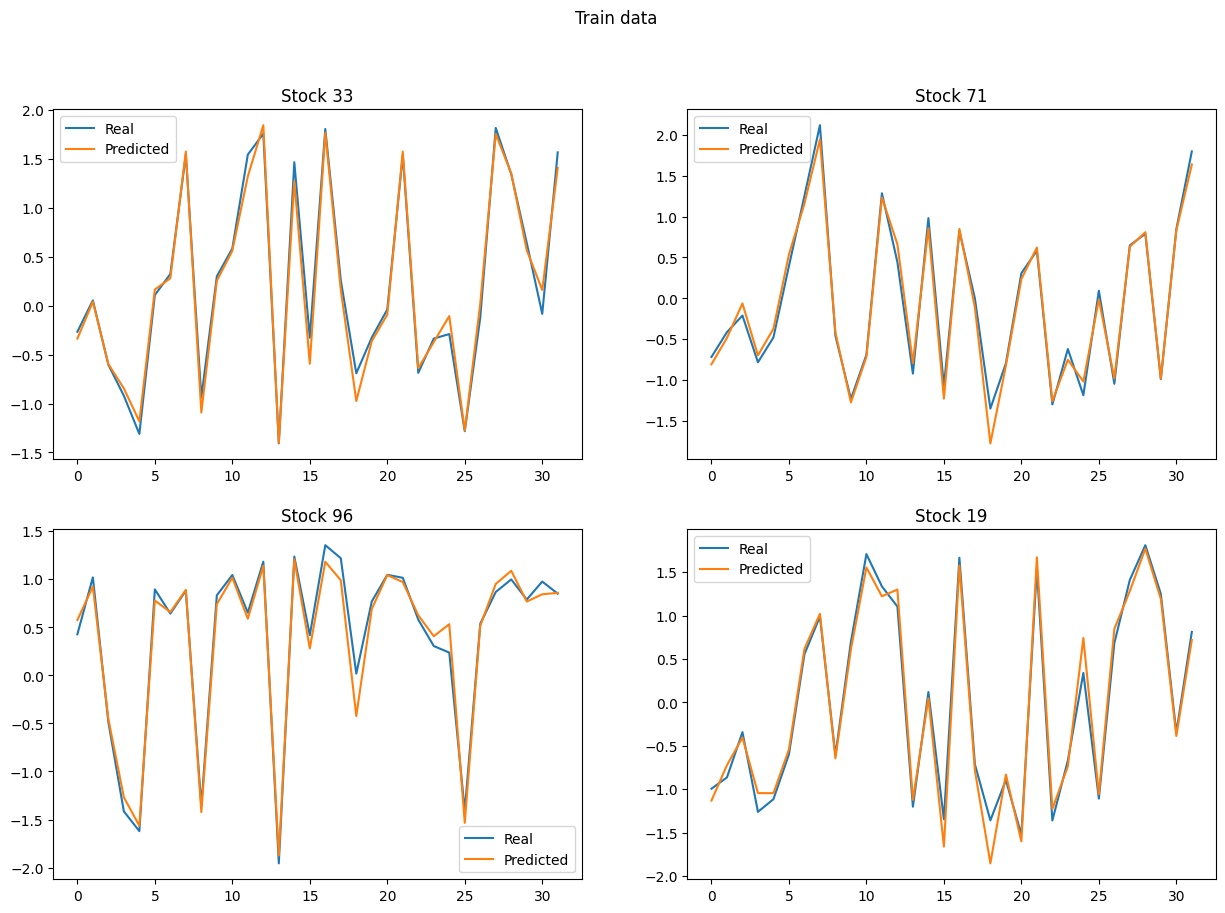

In [ ]:
plot_regression(model, next(iter(train_dataloader)), "Train data")


### Results on test data

In [ ]:
mse, rmse, mae, mre = get_regression_error(model, test_dataloader)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Test MSE: 0.0267, RMSE: 0.1635, MAE: 0.1013, MRE: 0.0866


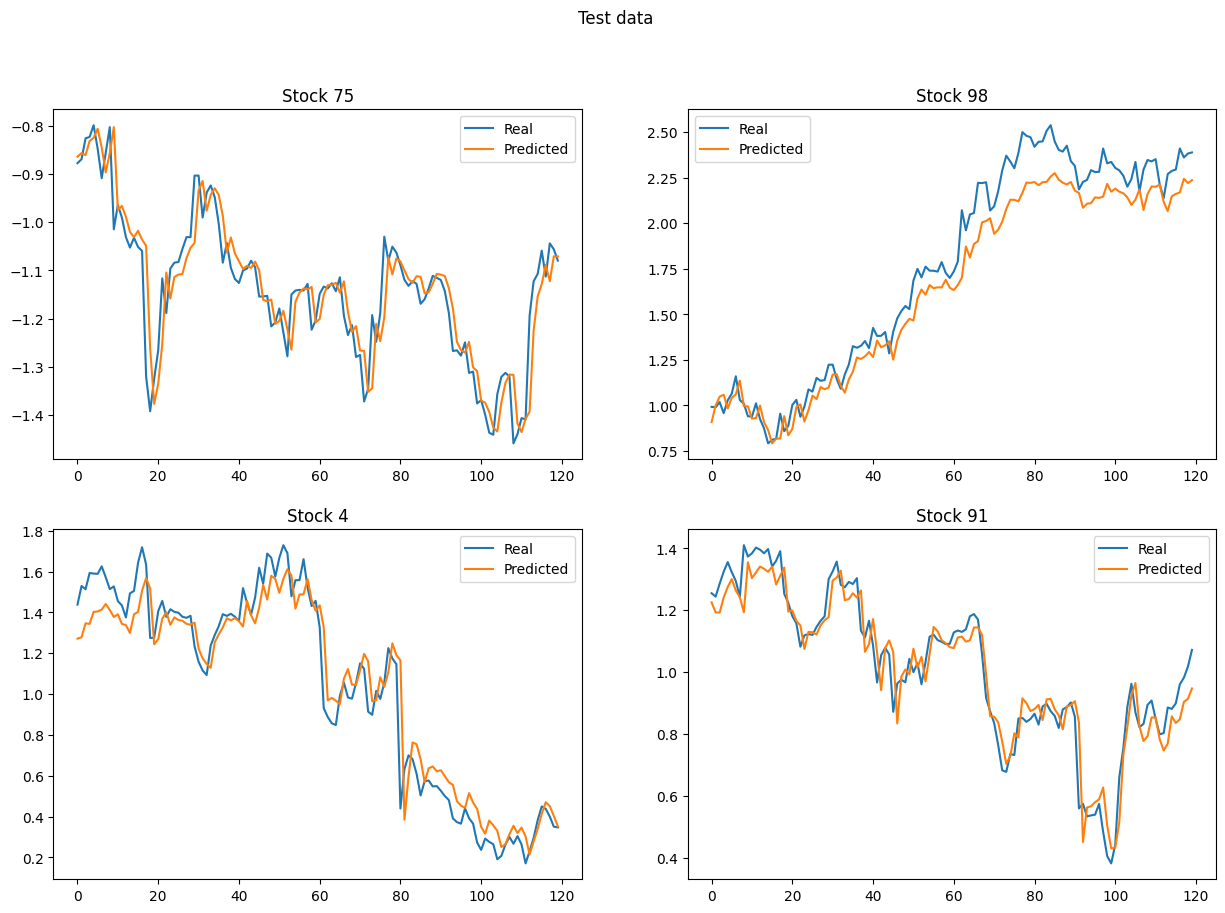

In [ ]:
plot_regression(model, next(iter(test_dataloader)), "Test data")


# Stocks clustering
The goal of this task is to cluster stocks based on their historical prices and the graph structure.


In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GAE
from torch_geometric.utils import to_dense_adj
from tqdm import trange

from notebooks.models import GCN

## get_stocks_labels

In [ ]:
def get_stocks_labels() -> list[str]:
	"""
	Retrieves the labels (symbols) of the dataset stocks
	:return: The list of stock labels
	"""
	return pd.read_csv("/content/drive/MyDrive/A+/Seminar FDA/data/SP100/raw/values.csv")["Symbol"].unique().tolist()

## Loading the data

In [ ]:
seq_len = 25
dataset = SP100Stocks(past_window=seq_len)
dataset, dataset[0]

Processing...
Done!


(SP100Stocks(1191),
 Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 1]))

In [ ]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

## Temporal Convolutional Graph Autoencoder
The Temporal Convolution Graph Autoencoder (TCGAE) is a model that combines the Graph Autoencoder (GAE) with a Convolutional Autoencoder (CAE) to encode the temporal graph data (the times series). The GAE is used to encode the graph structure of the stocks, while the CAE is used to encode the temporal information of the stocks using convolutional layers on the latent space of the GAE.

In [ ]:
class CAE(nn.Module):
	"""
	Convolutional autoencoder for temporal convolutional graph autoencoder.
	"""
	def __init__(self, in_channels: int, latent_dim: int, seq_len: int = 25):
		super(CAE, self).__init__()
		self.seq_len = seq_len
		self.encoder = nn.Sequential(
			nn.Conv1d(in_channels, latent_dim, 5, stride=3),
			nn.ReLU(),
			nn.Conv1d(latent_dim, latent_dim, 5, stride=3),
		)
		self.decoder = nn.Sequential(
			nn.ConvTranspose1d(latent_dim, latent_dim, 5, stride=2),
			nn.ReLU(),
			nn.ConvTranspose1d(latent_dim, latent_dim, 5, stride=2, padding=1),
			nn.ReLU(),
			nn.ConvTranspose1d(latent_dim, in_channels, 5, stride=2),
		)

	def encode(self, x: torch.tensor) -> torch.tensor:
		return self.encoder(x).squeeze(-1)

	def decode(self, z: torch.tensor) -> torch.tensor:
		return self.decoder(z.unsqueeze(-1))

	def loss(self, x: torch.tensor, z: torch.tensor) -> torch.tensor:
		return F.mse_loss(self.decode(z), x)

	def forward(self, x: torch.tensor) -> torch.tensor:
		return self.encode(x)

In [ ]:
class TCGAE(nn.Module):
	def __init__(self, in_channels: int, latent_dim: int, seq_len: int = 25):
		super(TCGAE, self).__init__()
		self.seq_len = seq_len
		self.hidden_dim = latent_dim // 2
		self.latent_dim = latent_dim
		self.gae = GAE(
			GCN(in_channels, [self.hidden_dim, self.hidden_dim]),
		)
		self.cae = CAE(self.hidden_dim, latent_dim, seq_len)

	def loss(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		recon_loss = 0
		latent_seq = torch.zeros(x.shape[0], self.hidden_dim, self.seq_len)
		for t in range(self.seq_len):
			latent_seq[:, :, t] = self.gae.encode(x[:, :, t], edge_index, edge_weight)
			recon_loss += self.gae.recon_loss(latent_seq[:, :, t], edge_index,)
		return self.cae.loss(latent_seq, self.cae(latent_seq)) + recon_loss / self.seq_len

	def encode(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		latent_seq = torch.zeros(x.shape[0], self.hidden_dim, self.seq_len)
		for i in range(self.seq_len):
			latent_seq[:, :, i] = self.gae.encode(x[:, :, i], edge_index, edge_weight)
		return self.cae(latent_seq)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		return self.encode(x, edge_index, edge_weight)

## Training
The model is trained using the Adam optimizer with a learning rate of 0.005 for 2 epochs.



In [ ]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader, epochs: int):
	writer = SummaryWriter(f'runs/StocksClustering_{datetime.now().strftime("%d_%m_%Hh%M")}_{model.__class__.__name__}')
	for epoch in (pbar := trange(epochs, desc='Epochs')):
		for i, data in enumerate(dataloader):
			optimizer.zero_grad()
			loss = model.loss(data.x, data.edge_index, data.edge_weight)
			loss.backward()
			optimizer.step()
			pbar.set_postfix({'Loss': loss.item(), 'Batch': f"{100*(i+1)/len(dataloader):.2f}%"})
			writer.add_scalar('Loss/Reconstruction Loss', loss.item(), epoch * len(dataloader) + i)

In [ ]:
in_channels, latent_dim = dataset[0].x.shape[1], 16
lr, num_epochs = 0.005, 2

model = TCGAE(in_channels, latent_dim, seq_len)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model

TCGAE(
  (gae): GAE(
    (encoder): GCN(
      (convs): ModuleList(
        (0-1): 2 x GCNConv(8, 8)
      )
    )
    (decoder): InnerProductDecoder()
  )
  (cae): CAE(
    (encoder): Sequential(
      (0): Conv1d(8, 16, kernel_size=(5,), stride=(3,))
      (1): ReLU()
      (2): Conv1d(16, 16, kernel_size=(5,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(16, 16, kernel_size=(5,), stride=(2,))
      (1): ReLU()
      (2): ConvTranspose1d(16, 16, kernel_size=(5,), stride=(2,), padding=(1,))
      (3): ReLU()
      (4): ConvTranspose1d(16, 8, kernel_size=(5,), stride=(2,))
    )
  )
)

In [ ]:
train(model, optimizer, dataloader, num_epochs)

Epochs: 100%|██████████| 2/2 [05:11<00:00, 155.77s/it, Loss=1.24, Batch=100.00%]


## Results
The stocks are encoded using the trained model, and then clustered with the KMeans algorithm. Then the clusters are visualized with a scatter plot and the graph structure.

## Clustering the stocks
The stocks are clustered using KMeans, and they are visualized in a 2D space using t-SNE.

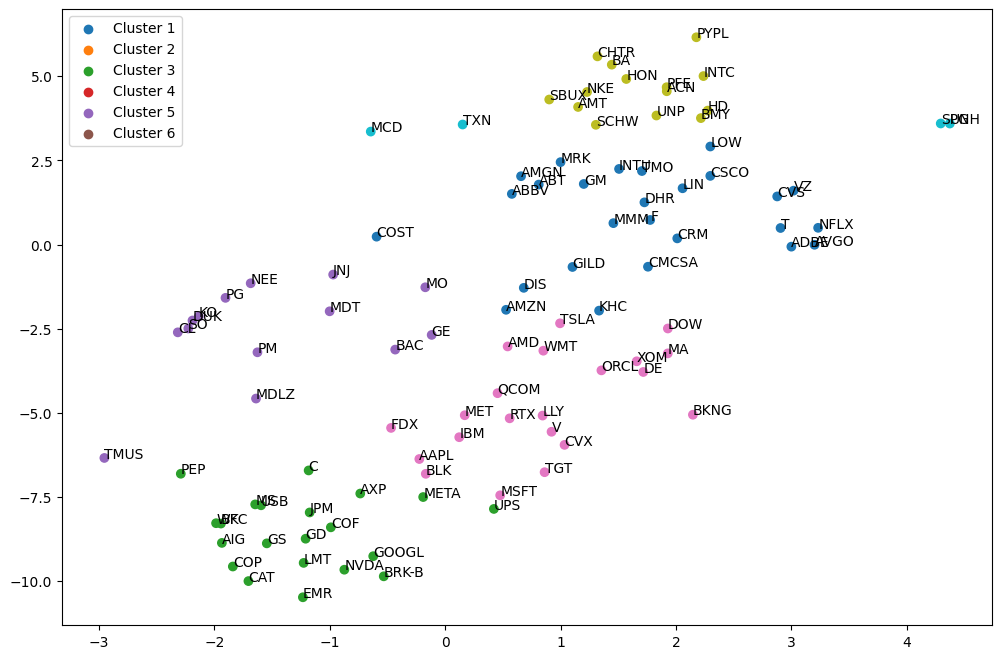

In [ ]:
data = dataset[-1]
n_clusters = 6
labels = get_stocks_labels()

z = model(data.x, data.edge_index, data.edge_weight).detach().numpy()

z_embedded = TSNE(n_components=2).fit_transform(z)
cluster_labels = KMeans(n_clusters=n_clusters, random_state=0).fit(z).labels_

plt.figure(figsize=(12, 8))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=cluster_labels, cmap='tab10')
for i, label in enumerate(labels):
	plt.annotate(label, (z_embedded[i, 0], z_embedded[i, 1]))

for i in range(n_clusters):
	plt.scatter([], [], c=f"C{i}", label=f"Cluster {i+1}")
plt.legend()
plt.show()

## Stocks variations
The variations of the stocks in each cluster can be visualized. Note that the variation is not the only factor that determines the clustering, as the graph structure is also considered. There are still variations tendencies in each cluster.

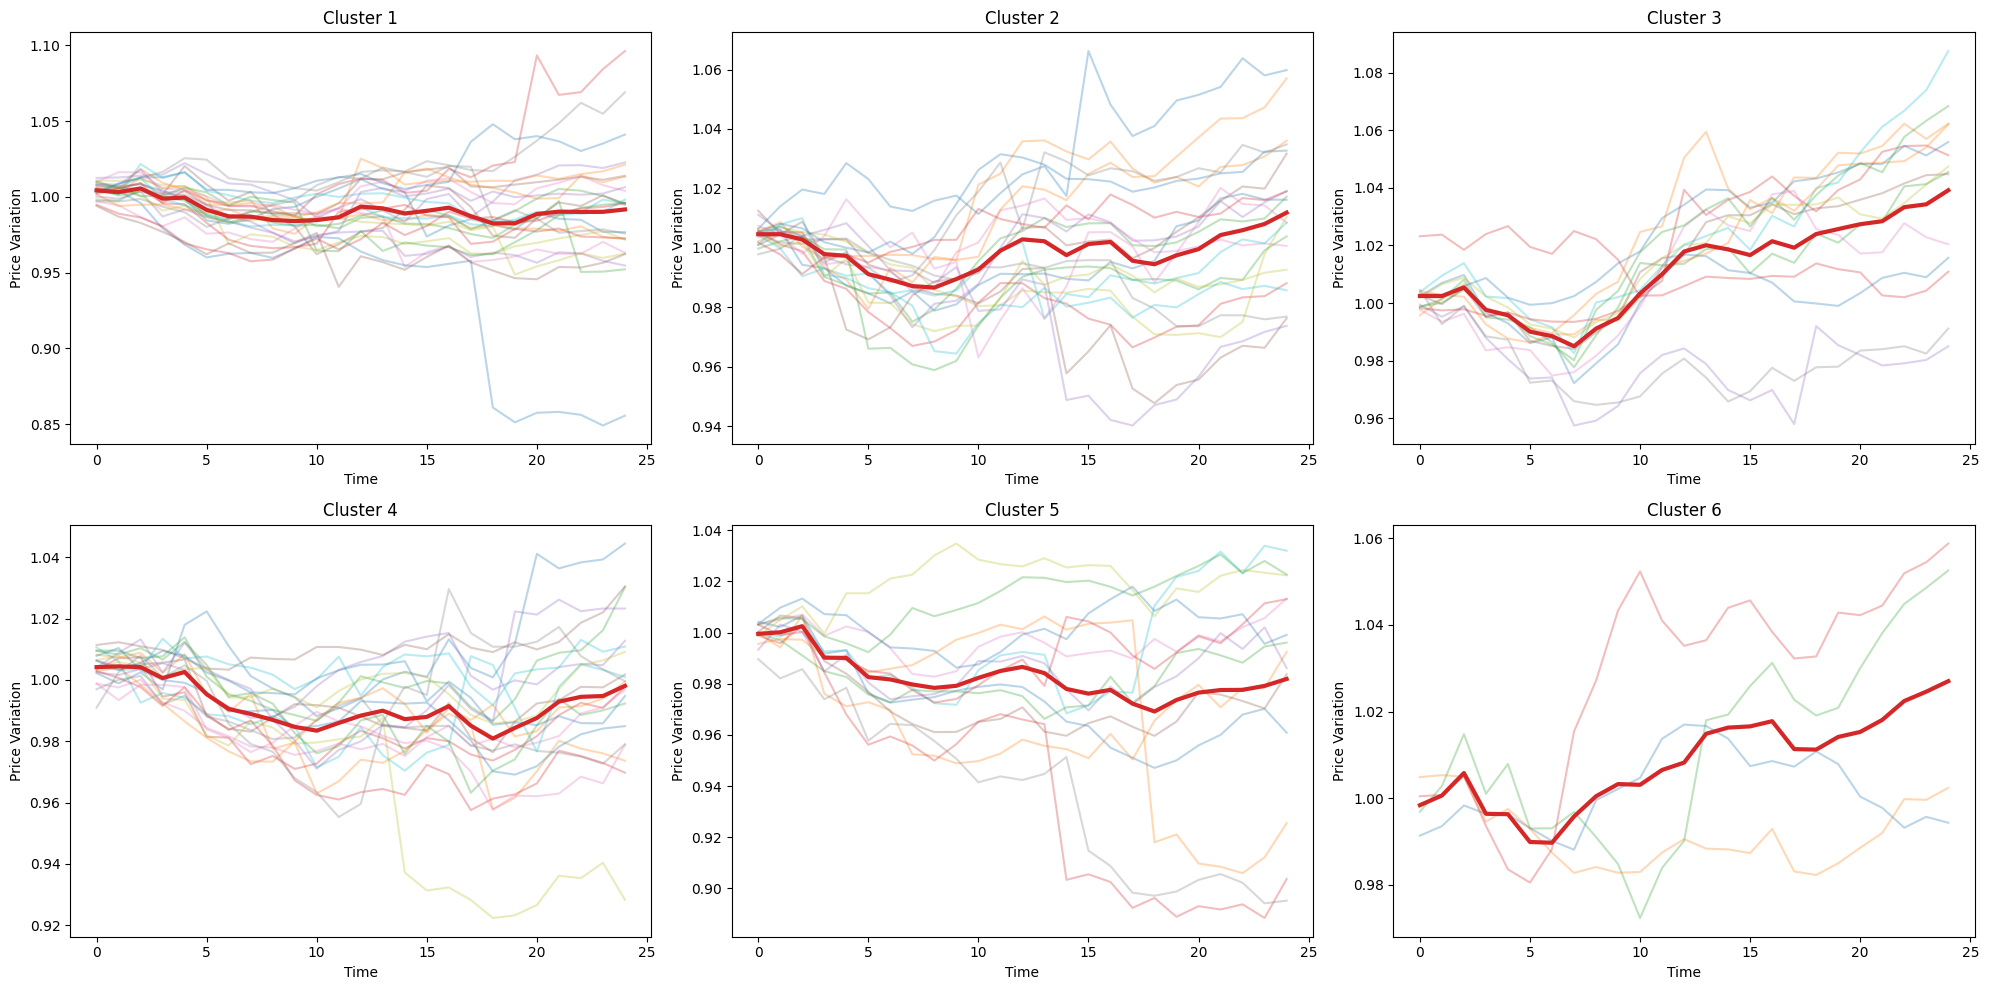

In [ ]:
cols = 3
fig, axs = plt.subplots(2, cols, figsize=(20, 10))
for i in range(n_clusters):
	ax = axs[i//cols, i%cols]
	ax.set_title(f'Cluster {i+1}')
	cluster_variations = []
	for j in np.where(cluster_labels == i)[0]:
		variations = np.cumprod(1 + data.x[j, 1, :].detach().numpy() / 100, axis=0)
		cluster_variations.append(variations)
		ax.plot(variations, alpha=0.3)
	ax.plot(np.array(cluster_variations).transpose().mean(axis=1), linewidth=3, c="C3")
	ax.set_xlabel('Time')
	ax.set_ylabel('Price Variation')
	# ax.set_yscale('log')
plt.tight_layout()
plt.show()

## Graph visualization
The graph structure of the stocks is visualized with the nodes colored by the cluster they belong to, for a more visual representation of the clustering.

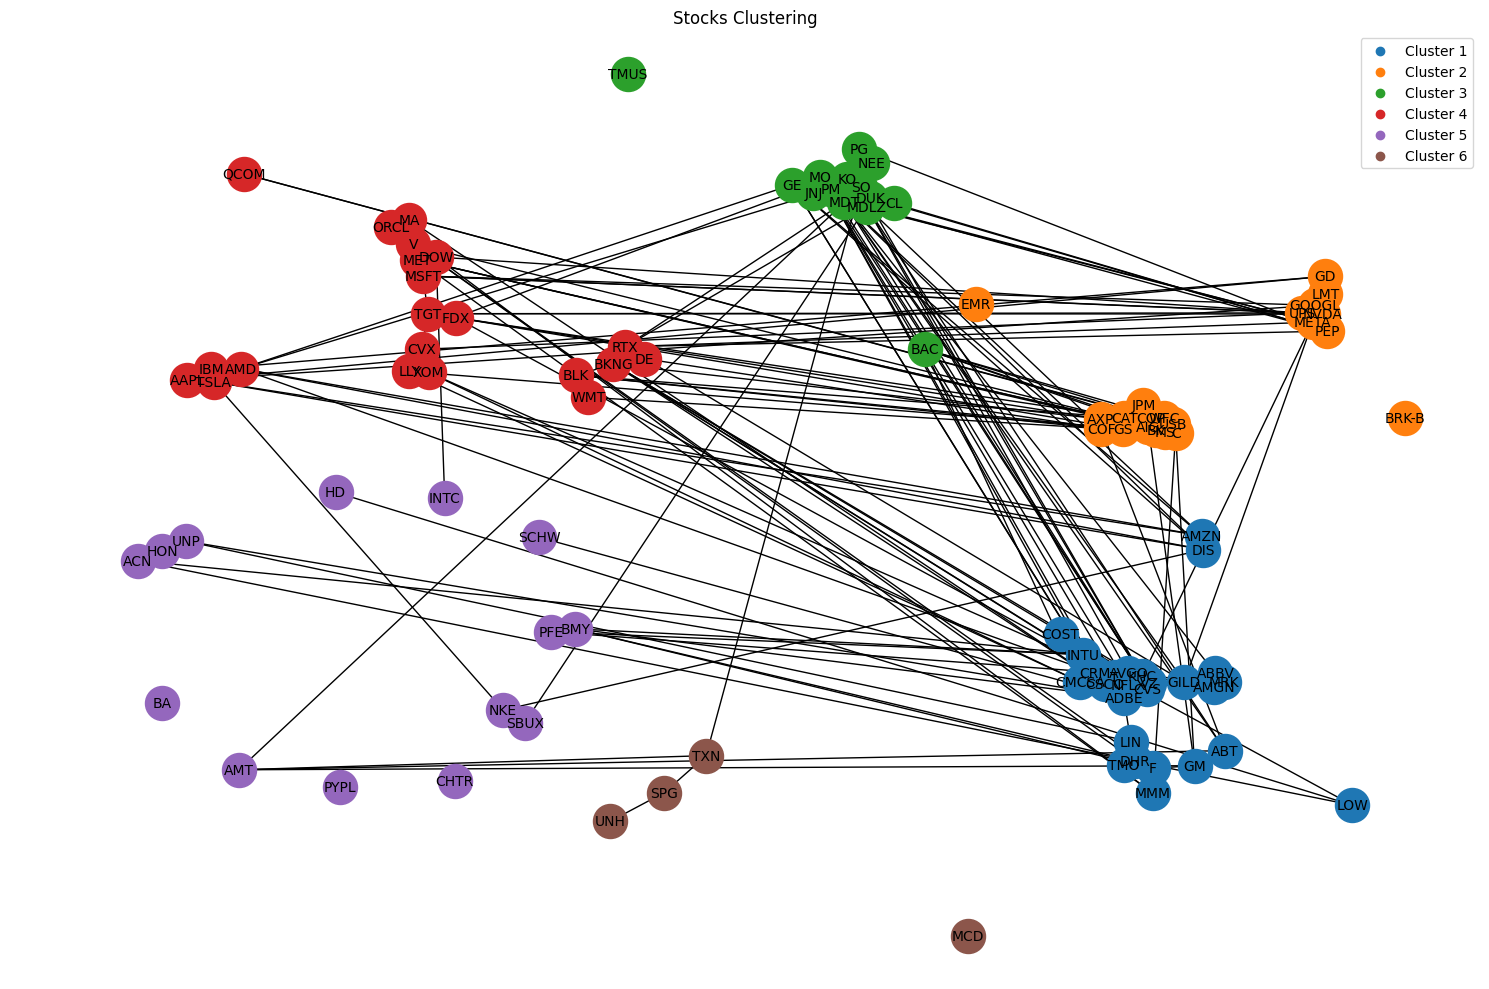

In [ ]:
adj = to_dense_adj(data.edge_index)[0].detach().numpy()

plt.figure(figsize=(15, 10))
G = nx.from_numpy_array(adj)
G = nx.relabel_nodes(G, {i: label for i, label in enumerate(labels)})

communities = [
	set(
		label for stock_idx, label in enumerate(labels) if stock_idx in cluster
	) for cluster in [np.where(cluster_labels == i)[0] for i in range(n_clusters)]
]

centers = list(nx.spring_layout(nx.cycle_graph(len(communities)), scale=14).values())
pos = {}
for center, comm in zip(centers, communities):
    pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, scale=7))

# Nodes colored by cluster
for nodes, clr in zip(communities, (f"C{i}" for i in range(len(communities)))):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_color=clr, node_size=600)

nx.draw_networkx_labels(G, pos=pos, font_size=10, font_color='black')
nx.draw_networkx_edges(G, pos=pos)

for i in range(n_clusters):
	plt.scatter([], [], c=f"C{i}", label=f"Cluster {i+1}")
plt.legend()
plt.axis("off")
plt.title("Stocks Clustering")
plt.tight_layout()
plt.show()

# Stock trend classification
The goal of this task is to classify the stock movement n weeks ahead as a binary up/down trend, based on historical data.

In [ ]:
import sys, os, importlib

PROJ = "/content/drive/MyDrive/A+/Seminar FDA"   # <— sửa đúng đường dẫn gốc chứa folder 'notebooks'
sys.path.insert(0, PROJ)                         # thêm project root vào PYTHONPATH

In [ ]:
os.makedirs(f"{PROJ}/notebooks/models", exist_ok=True)
for p in [f"{PROJ}/notebooks/__init__.py", f"{PROJ}/notebooks/models/__init__.py"]:
    if not os.path.exists(p): open(p, "a").close()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from notebooks.models import TGCN, A3TGCN, DCGNN, train, measure_accuracy, get_confusion_matrix

## Loading the data
The data from the custom PyG dataset for forecasting is loaded into a PyTorch dataloader. A "transform" is applied to change the targets y of the dataset to a binary buy/sell class instead of the close price.

In [ ]:
def future_close_price_to_buy_sell_class(sample: Data):
	"""
	Transforms the target y to a binary buy (1) if the stock return two weeks ahead was higher that the average market return, else sell (0)
	:param sample: Data sample
	:return: The transformed sample
	"""
	market_return = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).mean()
	sample.returns = ((sample.close_price_y[:, -1] - sample.close_price[:, -1]) / sample.close_price[:, -1]).unsqueeze(1)
	sample.market_return = market_return
	sample.y = (sample.returns >= 0).float()
	return sample

In [ ]:
def future_close_price_to_buy_sell_class(sample: Data) -> Data:
    # Lấy giá hiện tại và giá tương lai ở thời điểm cuối cửa sổ
    curr = sample.close_price[:, -1:]        # (N, 1)
    fut  = sample.close_price_y[:, -1:]      # (N, 1)  <-- chuẩn hóa về 1 bước

    # Tính return theo stock
    ret = (fut - curr) / curr                # (N, 1)

    # Gán các trường dùng cho training
    sample.returns = ret                     # (N, 1)
    sample.y = (ret > 0).float()             # (N, 1) nhãn 0/1
    sample.close_price_y = fut               # (N, 1)  <-- đồng nhất với y
    sample.market_return = ret.mean()        # scalar

    return sample

In [ ]:
weeks_ahead = 1
dataset = SP100Stocks(future_window=weeks_ahead*5,
                      force_reload=True,
                      transform=future_close_price_to_buy_sell_class)

Processing...
Done!


In [ ]:
weeks_ahead = 1

dataset = SP100Stocks(future_window=weeks_ahead * 5, force_reload=True, transform=future_close_price_to_buy_sell_class)
dataset, dataset[0]

Processing...
Done!


(SP100Stocks(1191),
 Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 5], returns=[100, 1], market_return=-0.01072738878428936))

In [ ]:
for i in range(0, 10):
	print(f"Stock return: {dataset[i].returns[i].item() * 100:.2f}%, trend: {['Down', 'Up'][int(dataset[i].y[i].item())]}")

Stock return: -1.87%, trend: Down
Stock return: -0.15%, trend: Down
Stock return: -1.05%, trend: Down
Stock return: 0.57%, trend: Up
Stock return: -0.37%, trend: Down
Stock return: -0.86%, trend: Down
Stock return: 2.05%, trend: Up
Stock return: -0.08%, trend: Down
Stock return: 2.44%, trend: Up
Stock return: 2.64%, trend: Up


In [ ]:
train_part = .9
batch_size = 32

train_dataset, test_dataset = dataset[:int(train_part * len(dataset))], dataset[int(train_part * len(dataset)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

Train dataset: 1071, Test dataset: 120


## Training
The previously implemented models are used, trained using the training dataset and the Adam optimizer. The weight_decay parameter is used for L2 regularization, to follow the T-GCN papers methodology. The loss is calculated using the Binary Cross Entropy (BCE) loss function.

In [ ]:
in_channels, out_channels, hidden_size, layers_nb, dropout = dataset[0].x.shape[-2], 1, 16, 2, .3
model = TGCN(in_channels, out_channels, hidden_size, layers_nb)

lr, weight_decay, num_epochs = 0.005, 1e-5, 100

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
model

TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GAT(
        (convs): ModuleList(
          (0): GATv2Conv(8, 16, heads=1)
          (1): GATv2Conv(16, 16, heads=1)
        )
      )
      (lin_u): Linear(in_features=40, out_features=16, bias=True)
      (lin_r): Linear(in_features=40, out_features=16, bias=True)
      (lin_c): Linear(in_features=40, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GAT(
        (convs): ModuleList(
          (0-1): 2 x GATv2Conv(16, 16, heads=1)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

In [ ]:
from collections import defaultdict
import torch

def check_shapes(ds, K=64):
    shapes = defaultdict(set)
    for i in range(min(K, len(ds))):
        d = ds[i]
        for k, v in d.items():
            if torch.is_tensor(v):
                shapes[k].add(tuple(v.shape))
            else:
                # scalar (float) sẽ bị coi như tensor 0-D
                pass
    return {k: sorted(list(v)) for k, v in shapes.items()}

print(check_shapes(train_dataset, 128))


{'x': [(100, 8, 25)], 'edge_index': [(2, 524)], 'y': [(100, 1)], 'edge_weight': [(524,)], 'close_price': [(100, 25)], 'close_price_y': [(100, 5)], 'returns': [(100, 1)], 'market_return': [()]}


In [ ]:
train(model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, "UpDownTrend", measure_acc=True)

Epochs: 100%|██████████| 100/100 [3:58:25<00:00, 143.06s/it, Batch=100.0%]


In [ ]:
torch.save(model.state_dict(), f"models/saved_models/UpDownTrend_{model.__class__.__name__}.pt")

## Results
### Results on train data

In [ ]:
# === 0) Mount Google Drive (nếu chưa) ===
from google.colab import drive
drive.mount('/content/drive')

# === 1) Imports & cấu hình đường dẫn dự án ===
import os, os.path as osp, sys, math
import numpy as np
import pandas as pd
import torch

from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

# chỉnh theo thư mục gốc dự án của bạn
PROJ = "/content/drive/MyDrive/A+/Seminar FDA"
if PROJ not in sys.path:
    sys.path.insert(0, PROJ)

# Tránh xung đột với gói 'datasets' bên ngoài
import importlib
sys.modules.pop("datasets", None); importlib.invalidate_caches()

# === 2) Hàm dựng graph từ dữ liệu (values.csv, adj.npy) ===
def get_graph_in_pyg_format(values_path: str, adj_path: str):
    """
    Trả về:
      x: (nodes_nb, features_nb, timestamps_nb)
      close_prices: (nodes_nb, timestamps_nb)
      edge_index: (2, edge_nb)
      edge_weight: (edge_nb,)
    """
    values = pd.read_csv(values_path).set_index(['Symbol', 'Date'])
    adj = np.load(adj_path)

    nodes_nb = len(adj)
    edge_nb  = int(np.count_nonzero(adj))

    # Features = all columns except 'Close', reshape theo (nodes, timestamps, features) rồi transpose
    x_np = values.drop(columns=["Close"]).to_numpy().reshape((nodes_nb, -1, values.shape[1]-1))
    x = torch.tensor(x_np, dtype=torch.float32).transpose(1, 2)  # -> (nodes, features, timestamps)

    # Close prices
    cp_np = values[["Close"]].to_numpy().reshape((nodes_nb, -1))
    close_prices = torch.tensor(cp_np, dtype=torch.float32)

    # Edges
    edge_index  = torch.zeros((2, edge_nb), dtype=torch.long)
    edge_weight = torch.zeros((edge_nb,),   dtype=torch.float32)
    c = 0
    for i in range(nodes_nb):
        for j in range(nodes_nb):
            w = adj[i, j]
            if w != 0:
                edge_index[0, c] = i
                edge_index[1, c] = j
                edge_weight[c] = w
                c += 1

    return x, close_prices, edge_index, edge_weight

# === 3) Dataset PyG: SP100 ===
class SP100Stocks(Dataset):
    def __init__(self,
                 root: str = f"{PROJ}/data/SP100",
                 values_file_name: str = "values.csv",
                 adj_file_name: str = "adj.npy",
                 past_window: int = 25,
                 future_window: int = 1,
                 force_reload: bool = False,
                 transform = None):
        self.values_file_name = values_file_name
        self.adj_file_name    = adj_file_name
        self.past_window      = int(past_window)
        self.future_window    = int(future_window)
        super().__init__(root, force_reload=force_reload, transform=transform)

    @property
    def raw_file_names(self):         # dữ liệu nằm trong <root>/raw/
        return [self.values_file_name, self.adj_file_name]

    @property
    def processed_file_names(self):   # để rỗng: luôn gọi process khi cần
        return []

    def download(self):               # dữ liệu đã có sẵn trên Drive
        pass

    def process(self):
        values_path = osp.join(self.raw_dir, self.values_file_name)
        adj_path    = osp.join(self.raw_dir, self.adj_file_name)

        x, close_prices, edge_index, edge_weight = get_graph_in_pyg_format(values_path, adj_path)

        last = x.shape[2] - self.past_window - self.future_window
        os.makedirs(self.processed_dir, exist_ok=True)

        for t in range(max(last, 0)):
            data = Data(
                x=x[:, :, t:t+self.past_window],
                edge_index=edge_index,
                edge_weight=edge_weight,
                close_price=close_prices[:, t:t+self.past_window],
                y=x[:, 0, t+self.past_window:t+self.past_window+self.future_window],
                close_price_y=close_prices[:, t+self.past_window:t+self.past_window+self.future_window],
            )
            torch.save(data, osp.join(self.processed_dir, f"timestep_{t}.pt"))

    def len(self):
        if not osp.isdir(self.processed_dir):
            return 0
        return sum(
            f.startswith("timestep_") and f.endswith(".pt")
            for f in os.listdir(self.processed_dir)
        )

    def get(self, idx):
        path = osp.join(self.processed_dir, f"timestep_{idx}.pt")
        return torch.load(path, map_location="cpu", weights_only=False)

# === 4) Transform: chuyển y sang bài toán Up/Down ===
from torch_geometric.data import Data
def future_close_price_to_buy_sell_class(sample: Data) -> Data:
    curr = sample.close_price[:, -1:]         # (N,1)
    fut  = sample.close_price_y[:, -1:]       # (N,1)
    ret  = (fut - curr) / (curr + 1e-8)       # (N,1)

    sample.returns       = ret
    sample.y             = (ret > 0).float()  # (N,1)
    sample.close_price_y = fut                # (N,1)
    sample.market_return = ret.mean()         # scalar
    return sample

# === 5) Hàm đánh giá: Accuracy & Confusion Matrix ===
@torch.no_grad()
def measure_accuracy(model, batch):
    model.eval()
    out = model(batch.x, batch.edge_index, batch.edge_weight).float()
    y   = batch.y.float()
    if out.shape != y.shape:
        out = out.reshape_as(y)
    pred = (out > 0).long().view(-1)
    true = (y   > 0).long().view(-1)
    acc  = (pred == true).float().mean().item()
    return acc, pred, true

def get_confusion_matrix(pred, true):
    tp = int(((pred==1) & (true==1)).sum().item())
    tn = int(((pred==0) & (true==0)).sum().item())
    fp = int(((pred==1) & (true==0)).sum().item())
    fn = int(((pred==0) & (true==1)).sum().item())
    return {"TP": tp, "TN": tn, "FP": fp, "FN": fn}

# === 6) Tạo dataset + split train/test ===
weeks_ahead = 1
dataset = SP100Stocks(
    future_window = weeks_ahead*5,
    force_reload  = True,
    transform     = future_close_price_to_buy_sell_class
)

train_part = 0.9
n_train    = int(train_part * len(dataset))
train_dataset = dataset[:n_train]
test_dataset  = dataset[n_train:]

# full-batch loader để đo acc/cm cho toàn bộ tập
train_loader_full = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
test_loader_full  = DataLoader(test_dataset,  batch_size=len(test_dataset),  shuffle=False)

# === 7) Khởi tạo & nạp trọng số model đã train (TGCN) ===
# Bạn cần có file .pt đã lưu state_dict
MODEL_PATH = f"{PROJ}/notebooks/models/saved_models/UpDownTrend_TGCN.pt"

# Import model định nghĩa trong dự án của bạn
from notebooks.models import TGCN  # hoặc: from notebooks.models.TGCN import TGCN

in_channels  = dataset[0].x.shape[-2]  # ví dụ 8
out_channels = 1
hidden_size  = 16
layers_nb    = 2

model = TGCN(in_channels, out_channels, hidden_size, layers_nb)
state = torch.load(MODEL_PATH, map_location="cpu")
model.load_state_dict(state)
model.eval()

# === 8) Đánh giá Train/Test ===
full_train = next(iter(train_loader_full))
acc_tr, pred_tr, true_tr = measure_accuracy(model, full_train)
cm_tr = get_confusion_matrix(pred_tr, true_tr)
print(f"Train accuracy: {acc_tr*100:.1f}%")
print("Train confusion matrix:", cm_tr)

full_test = next(iter(test_loader_full))
acc_te, pred_te, true_te = measure_accuracy(model, full_test)
cm_te = get_confusion_matrix(pred_te, true_te)
print(f"Test  accuracy: {acc_te*100:.1f}%")
print("Test  confusion matrix:", cm_te)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing...
Done!


Train accuracy: 71.1%
Train confusion matrix: {'TP': 53503, 'TN': 22632, 'FP': 26443, 'FN': 4522}
Test  accuracy: 48.9%
Test  confusion matrix: {'TP': 3179, 'TN': 2684, 'FP': 2235, 'FN': 3902}


### Results on test data


In [ ]:
import os, os.path as osp
from typing import Callable
import pandas as pd
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
import sys

# Ensure PROJ path is in sys.path for module imports
PROJ = "/content/drive/MyDrive/A+/Seminar FDA"   # Update if your project root changes
if PROJ not in sys.path:
    sys.path.insert(0, PROJ)

import numpy as np

# Import the necessary functions for metrics and models
from notebooks.models import measure_accuracy, get_confusion_matrix, TGCN

# Definition of get_graph_in_pyg_format (from D_3d4-mgjr5s)
def get_graph_in_pyg_format(values_path: str, adj_path: str) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
	"""
	Creates the PyTorch Geometric graph data from the stock price data and adjacency matrix.
	:param values_path: Path of the CSV file containing the stock price data
	:param adj_path: Path of the NumPy file containing the adjacency matrix
	:return: The graph data in PyTorch Geometric format
		x: Node features (nodes_nb, timestamps_nb, features_nb)
		close_prices: Close prices (nodes_nb, timestamps_nb)
		edge_index: Edge index (2, edge_nb)
		edge_weight: Edge weight (edge_nb,)
	"""
	values = pd.read_csv(values_path).set_index(['Symbol', 'Date'])
	adj = np.load(adj_path)
	nodes_nb = len(adj)
	edge_nb = np.count_nonzero(adj) # Correctly count only non-zero elements

	x = torch.tensor(
		values.drop(columns=["Close"]).to_numpy().reshape((nodes_nb, -1, values.shape[1] - 1)), dtype=torch.float32
	)
	x = x.transpose(1, 2)
	close_prices = torch.tensor(
		values[["Close"]].to_numpy().reshape((nodes_nb, -1)), dtype=torch.float32
	)
	edge_index, edge_weight = torch.zeros((2, edge_nb), dtype=torch.long), torch.zeros((edge_nb,), dtype=torch.float32)
	count = 0
	for i in range(nodes_nb):
		for j in range(nodes_nb):
			if (weight := adj[i, j]) != 0:
				edge_index[0, count], edge_index[1, count] = i, j
				edge_weight[count] = weight
				count += 1 # Increment count ONLY when an edge is added

	return x, close_prices, edge_index, edge_weight

# Definition of SP100Stocks class (from F0rEJF7H0t4b)
class SP100Stocks(Dataset):
    """
    Stock price data for the S&P 100 companies.
    The graph data built from the notebooks is used.
    """

    def __init__(self,
                 root: str = "/content/drive/MyDrive/A+/Seminar FDA/data/SP100",
                 values_file_name: str = "values.csv",
                 adj_file_name: str = "adj.npy",
                 past_window: int = 25,
                 future_window: int = 1,
                 force_reload: bool = False,
                 transform: Callable | None = None):
        self.values_file_name = values_file_name
        self.adj_file_name = adj_file_name
        self.past_window = int(past_window)
        self.future_window = int(future_window)
        super().__init__(root, force_reload=force_reload, transform=transform)

    @property
    def raw_file_names(self) -> list[str]:
        # các file sẽ nằm trong <root>/raw/
        return [self.values_file_name, self.adj_file_name]

    @property
    def processed_file_names(self) -> list[str]:
        # để rỗng để PyG luôn gọi process() khi cần
        return []

    def download(self) -> None:
        pass

    def process(self) -> None:
        # dùng đường dẫn trong <root>/raw/ thay vì hard-code
        values_path = osp.join(self.raw_dir, self.values_file_name)
        adj_path    = osp.join(self.raw_dir, self.adj_file_name)

        x, close_prices, edge_index, edge_weight = get_graph_in_pyg_format(
            values_path=values_path,
            adj_path=adj_path,
        )

        last = x.shape[2] - self.past_window - self.future_window
        os.makedirs(self.processed_dir, exist_ok=True)

        for idx in range(max(last, 0)):
            data = Data(
                x=x[:, :, idx:idx + self.past_window],
                edge_index=edge_index,
                edge_weight=edge_weight,
                close_price=close_prices[:, idx:idx + self.past_window],
                y=x[:, 0, idx + self.past_window:idx + self.past_window + self.future_window],
                close_price_y=close_prices[:, idx + self.past_window:idx + self.past_window + self.future_window],
            )
            torch.save(data, osp.join(self.processed_dir, f"timestep_{idx}.pt"))

    def len(self) -> int:
        if not osp.isdir(self.processed_dir):
            return 0
        return sum(
            f.startswith("timestep_") and f.endswith(".pt")
            for f in os.listdir(self.processed_dir)
        )

    def get(self, idx: int) -> Data:
        path = osp.join(self.processed_dir, f"timestep_{idx}.pt")
        # PyTorch 2.6+: phải tắt weights_only khi load object Data của PyG
        return torch.load(path, map_location="cpu", weights_only=False)

# Definition of future_close_price_to_buy_sell_class (from X1bovYtML5la)
def future_close_price_to_buy_sell_class(sample: Data) -> Data:
    # Lấy giá hiện tại và giá tương lai ở thời điểm cuối cửa sổ
    curr = sample.close_price[:, -1:]        # (N, 1)
    fut  = sample.close_price_y[:, -1:]      # (N, 1)  <-- chuẩn hóa về 1 bước

    # Tính return theo stock
    ret = (fut - curr) / curr                # (N, 1)

    # Gán các trường dùng cho training
    sample.returns = ret                     # (N, 1)
    sample.y = (ret > 0).float()             # (N, 1) nhãn 0/1
    sample.close_price_y = fut               # (N, 1)  <-- đồng nhất với y
    sample.market_return = ret.mean()        # scalar

    return sample

# Dataset splitting and model loading
weeks_ahead = 1
dataset = SP100Stocks(future_window=1, force_reload=True, transform=future_close_price_to_buy_sell_class)

train_part = .9
train_dataset, test_dataset = dataset[:int(train_part * len(dataset))], dataset[int(train_part * len(dataset)):]

# Initialize and load the model
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 1, 16, 2
model = TGCN(in_channels, out_channels, hidden_size, layers_nb)
model.load_state_dict(torch.load(f"{PROJ}/notebooks/models/saved_models/UpDownTrend_TGCN.pt"))
model.eval() # Set model to evaluation mode

# Create test_dataloader
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

acc, cm = measure_accuracy(model, next(iter(test_dataloader))), get_confusion_matrix(model, next(iter(test_dataloader)))

print(f"Test accuracy: {acc * 100:.1f}%\nTest confusion matrix:\n{cm}")

Processing...
Done!


Test accuracy: 50.5%
Test confusion matrix:
[[3033 2389]
 [3553 3025]]


# Optimal stock portfolio selection
This notebook illustrates the use of the previously trained classifier for optimal stock portfolio selection. Similarly to G. Pacreau et al., Graph Neural Networks for Asset Management, a softmax is applied to the output of the network to get the probability of the stock going up, and the top n stocks are selected to form the portfolio. It is evaluated compared to the market return, which is the average return of all the stocks in the dataset.

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from notebooks.models import TGCN

## Loading the data
The data from the custom PyG dataset for forecasting is loaded into a PyTorch dataloader.

In [ ]:
weeks_ahead = 1

dataset = SP100Stocks(future_window=weeks_ahead * 5)
dataset, dataset[0]

Processing...
Done!


(SP100Stocks(1191),
 Data(x=[100, 8, 25], edge_index=[2, 524], y=[100, 5], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 5]))

In [ ]:
train_part = .9

test_data = dataset[int(len(dataset) * train_part):]  # each day
test_data = [test_data[idx] for idx in range(0, len(test_data), 5)]  # each week
test_data[0].return_since_previous = torch.zeros(test_data[0].x.size(0))
for idx in range(1, len(test_data)):
	test_data[idx].return_since_previous = (test_data[idx].close_price[:, -1] / test_data[0].close_price[:, -1] - 1)
print(f"Test data: {len(test_data)} weeks")

Test data: 24 weeks


## Loading the model
The previously trained model is loaded.

In [ ]:
in_channels, out_channels, hidden_size, layers_nb = dataset[0].x.shape[-2], 1, 16, 2

model = TGCN(in_channels, out_channels, hidden_size, layers_nb)
model.load_state_dict(torch.load("/content/drive/MyDrive/A+/Seminar FDA/notebooks/models/saved_models/UpDownTrend_TGCN.pt"))
model

TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GAT(
        (convs): ModuleList(
          (0): GATv2Conv(8, 16, heads=1)
          (1): GATv2Conv(16, 16, heads=1)
        )
      )
      (lin_u): Linear(in_features=40, out_features=16, bias=True)
      (lin_r): Linear(in_features=40, out_features=16, bias=True)
      (lin_c): Linear(in_features=40, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GAT(
        (convs): ModuleList(
          (0-1): 2 x GATv2Conv(16, 16, heads=1)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

## Portfolio selection

In [ ]:
def get_topk(model_out: torch.tensor, k: int, largest: bool = True) -> torch.tensor:
		return torch.topk(model_out, k, largest=largest).indices

In [ ]:
topks = [5, 10, 20]

portfolio_returns = [[1.] for _ in range(len(topks))]
market_returns = [1.]

model_out = model(test_data[0].x, test_data[0].edge_index, test_data[0].edge_weight).squeeze(1)
last_close = test_data[0].close_price[:, -1]

for idx in range(1, len(test_data)):
	returns = test_data[idx].close_price[:, -1] / last_close
	for j, k in enumerate(topks):
		topk_stocks = get_topk(model_out, k, largest=False)
		portfolio_returns[j].append(returns[topk_stocks].mean().item() * portfolio_returns[j][-1])
	market_returns.append(returns.mean().item() * market_returns[-1])
	last_close = test_data[idx].close_price[:, -1]
	model_out = model(test_data[idx].x, test_data[idx].edge_index, test_data[idx].edge_weight).squeeze(1)

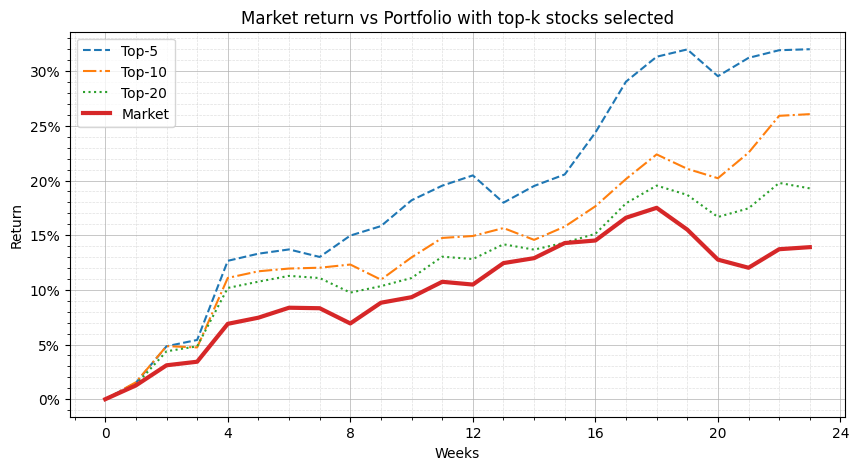

In [ ]:
plt.figure(figsize=(10, 5))

for j, k in enumerate(topks):
	plt.plot(portfolio_returns[j], label=f"Top-{k}", linestyle=['--', '-.', ':'][j])
plt.plot(market_returns, label="Market", linewidth=3)
plt.grid(which='major', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle='--', linewidth=0.5, alpha=.4)
plt.title(f"Market return vs Portfolio with top-k stocks selected")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{(x - 1) * 100:.0f}%"))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(4))
plt.legend()
plt.xlabel("Weeks")
plt.ylabel("Return")
plt.show()